<div style="display: flex; background-color: RGB(192,0,0);" >
<h1 style="margin: auto; padding: 30px; ">ANALYSE DU STOCK ET DES VENTES DU SITE BOTTLENECK</h1>
</div>

# Mission :


**Contexte et Difficultés Actuelles** :

Nos outils sont artisanaux, rendant l'analyse des données et la gestion des stocks complexes.

## Phase 1 - Agrégation des Données :

**Objectif** : Agréger les différents fichiers pour exploiter les données.

Étapes :
* Rapprocher l'extraction de la BDD avec la base de données ERP via la table de liaison.
* Identifier au moins 8 types d'erreurs dans les données (saisie, type, calcul, jointure, etc.).
* Proposer des solutions pour améliorer les données.


## Phase 2 - Analyse des Données pour le CODIR :

**Objectif** : Analyser les données pour le comité de direction et présenter les analyses.

Analyses à réaliser :
* Calculer le chiffre d’affaires par produit et le total général.
* Travailler sur les tops références, le 20/80, etc.
* Vérifier les erreurs de saisie en détectant des valeurs aberrantes (Z-Score ou écart interquartile).
* Extraire et analyser les valeurs aberrantes dans les prix (utiliser un boxplot).
* Analyser l’état des stocks, les taux de marge, la rotation des stocks, ou le nombre de mois de stock.

Analyse de corrélations :

* Analyser la corrélation entre certaines données quantitatives (prix, prix d’achat, stock, ventes, prix HT, taux de marge, etc.).



<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies</h3>
</div>

In [776]:
#Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import missingno as msno
import statsmodels.api as sm

In [777]:
# Afficher toutes les colonnes d'un dataframe
pd.set_option("display.max_columns", None)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fichiers</h3>
</div>

In [778]:
#Importation du fichier web.xlsx
df_web = pd.read_excel("web.xlsx")

#Importation du fichier erp.xlsx
df_erp = pd.read_excel("erp.xlsx")

#importation du fichier liaison.xlsx
df_liaison = pd.read_excel("liaison.xlsx")

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed



<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fonctions</h3>
</div>

In [779]:
# Création de la fonction description variables ou dataset

def description_variables(df):
    # Afficher le type de la variable
    type_variable = df.dtypes

    # Nombre de lignes totales
    nb_lignes = len(df.index)

    # Nombre total de valeurs dans chaque colonne
    total_values = df.count() #df.shape[0]

    # Nombre de valeurs uniques dans chaque colonnes
    valeurs_uniques = df.nunique()

    # Nombre de doublons dans chaque colonne
    #nb_doublons = df.duplicated().sum()

    # Calculer le nombre de valeurs manquantes pour chaque colonne
    missing_counts = df.isnull().sum()
    
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentage = (missing_counts / df.shape[0] * 100).round(2)

    
    # Créer un DataFrame avec les résultats
    variables_infos = pd.DataFrame({
        'type' : type_variable,
        'total' : nb_lignes,
        'n': total_values,
        'unique' : valeurs_uniques,
        #'doublons' : nb_doublons,
        'NaN': missing_counts,
        'pourcentage_(NaN)': missing_percentage
    })
    
     # Trier par 'pourcentage_(NaN)' dans l'ordre décroissant
    variables_infos = variables_infos.sort_values(by='pourcentage_(NaN)', ascending=False)
    
    print("Description donnée(s):")
    print("Le jeu de données comporte: {} observation(s)".format(df.shape[0]))
    print("Le jeu de données comporte: {} colonne(s)".format(df.shape[1]))

    return variables_infos

In [780]:
def statistiques_descriptives(data):
    # Vérifier si l'argument est une Series ou un DataFrame
    if isinstance(data, pd.Series):
        df = data.to_frame()
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        raise TypeError("L'argument doit être une Series ou un DataFrame de pandas")
    
    # Sélectionner seulement les colonnes numériques
    df_numeric = df.select_dtypes(include='number')
    
    # Nombre total de valeurs dans chaque colonne
    valeurs_totales = df_numeric.count()
    # Nombre de valeurs uniques dans chaque colonne
    valeurs_uniques = df_numeric.nunique()
    # Valeur minimum dans chaque colonne 
    minimum = df_numeric.min()
    # Moyenne dans chaque colonne
    moyenne = df_numeric.mean()
    # 1er quantile dans chaque colonne
    q1 = df_numeric.quantile(0.25)
    # Mediane dans chaque colonne
    mediane = df_numeric.median()
    # 3e quantile dans chaque colonne
    q3 = df_numeric.quantile(0.75)
    # Calcul de l'intervalle interquartile - IQR
    iqr = q3 - q1
    # Valeur maximum dans chaque colonne
    maximum = df_numeric.max()
    # Ecart-type dans chaque colonne
    std = df_numeric.std()
    # Variance dans chaque colonne
    variance = df_numeric.var()
    # Skewness dans chaque colonne
    skewness = df_numeric.skew()
    # Kurtosis dans chaque colonne
    kurtosis = df_numeric.kurtosis()

    # Créer un DataFrame avec les résultats
    stats_descriptives = pd.DataFrame({
        'n': valeurs_totales,
        'unique': valeurs_uniques,
        'min': minimum,
        'max': maximum,
        'moy': moyenne,
        'mediane': mediane,
        'q1': q1,
        'iqr': iqr,
        'q3': q3,
        'std': std,
        'var': variance,
        'skew': skewness,
        'kurt': kurtosis
    })

    print("Statistiques descriptives:")
    return stats_descriptives

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Analyse exploratoire du fichier erp.xlsx</h3>
</div>

In [781]:
# Descriptions des variables du dataset erp
description_variables(df_erp)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 6 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_id,int64,825,825,825,0,0.0
onsale_web,int64,825,825,2,0,0.0
price,float64,825,825,383,0,0.0
stock_quantity,int64,825,825,84,0,0.0
stock_status,object,825,825,2,0,0.0
purchase_price,float64,825,825,660,0,0.0


In [782]:
#Afficher les 5 premières lignes de la table
df_erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price
0,3847,1,24.2,16,instock,12.88
1,3849,1,34.3,10,instock,17.54
2,3850,1,20.8,0,outofstock,10.64
3,4032,1,14.1,26,instock,6.92
4,4039,1,46.0,3,outofstock,23.77


<Axes: >

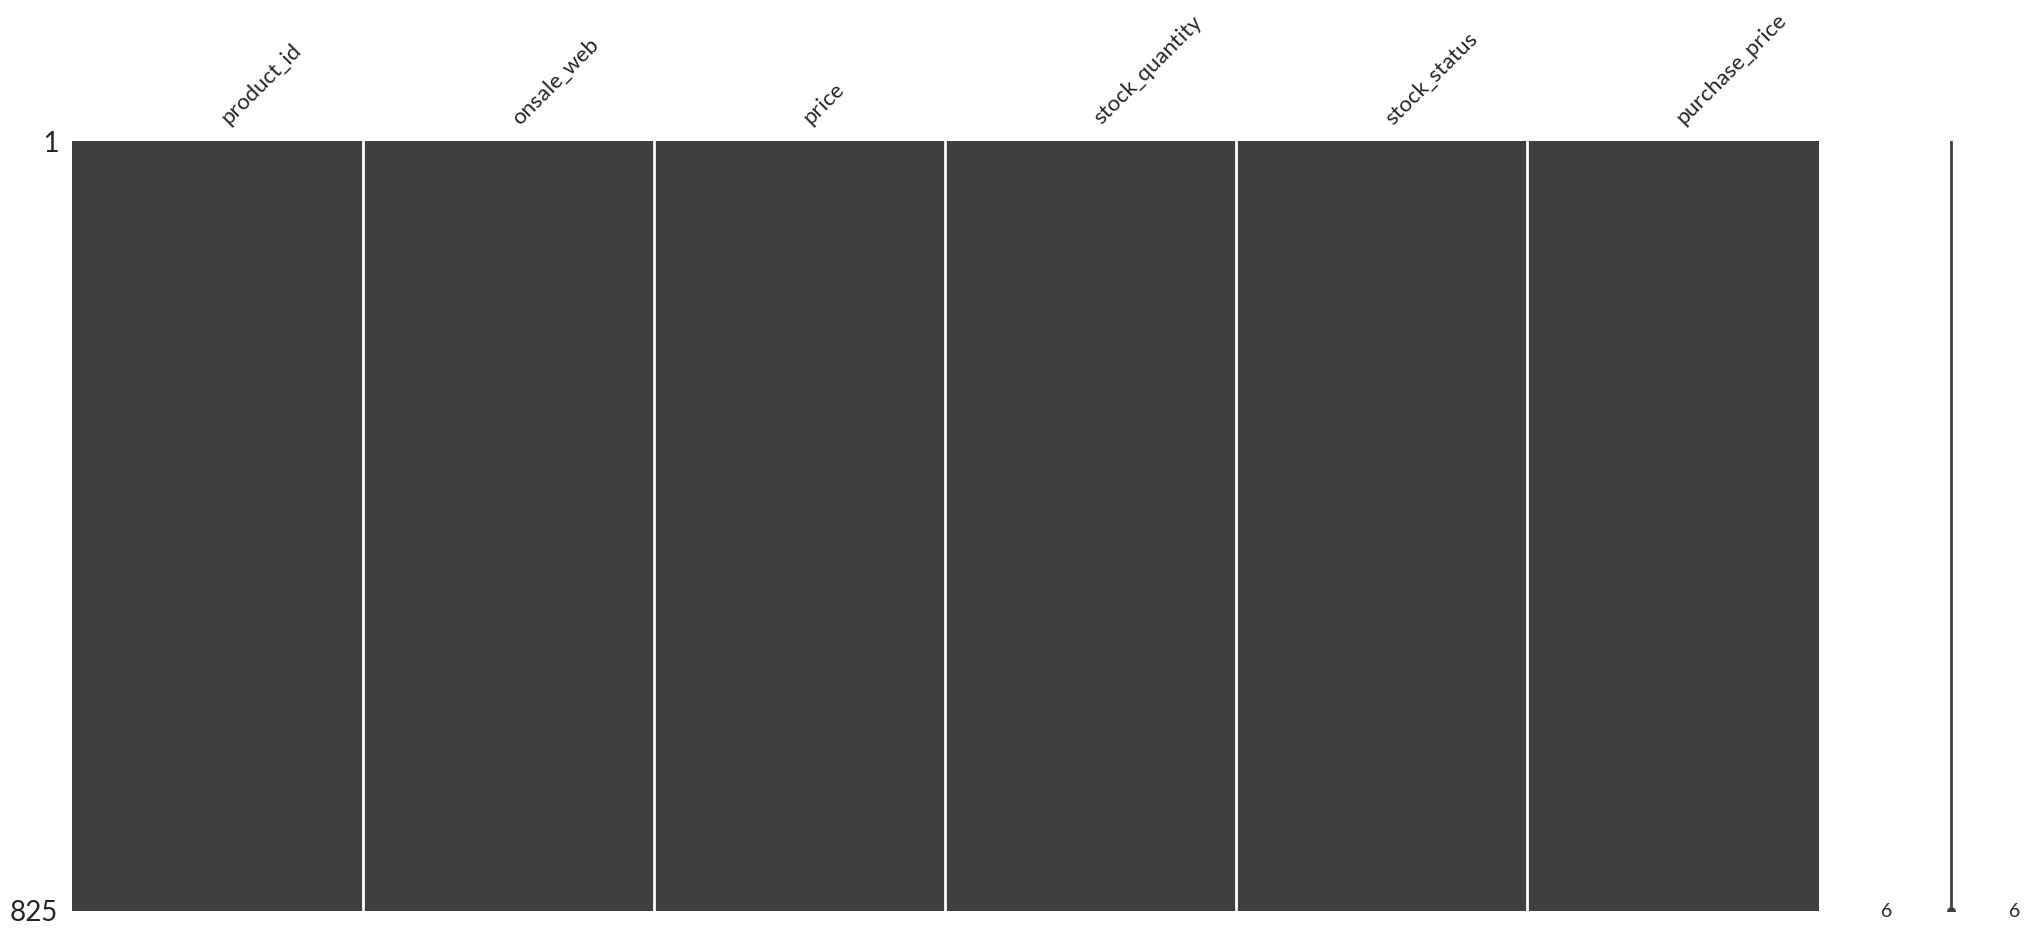

In [783]:
# Visualiser les données manquantes
msno.matrix(df_erp)

In [784]:
# Afficher le nombre de doublons de la variable product_id
product_id_unique = df_erp['product_id'].duplicated().sum()
print("La variable product_id comporte {} doublons".format(product_id_unique))

La variable product_id comporte 0 doublons


In [785]:
#Afficher les valeurs distinctes de la colonne stock_status
#À quelle(s) autre(s) colonne(s) sont-elles liées ?
df_erp["stock_status"].value_counts()

stock_status
instock       733
outofstock     92
Name: count, dtype: int64

La colonne stock_status est liée à stock_quantity

In [786]:
df_erp["stock_status_2"] = df_erp["stock_quantity"] > 0

In [787]:
# Tableau croisé
resultat_crosstab = pd.crosstab(df_erp["stock_status"], df_erp["stock_status_2"])
resultat_crosstab.head()

stock_status_2,False,True
stock_status,,
instock,1,732
outofstock,91,1


In [788]:
# Remplacer les booléens par les valeurs de texte correspondantes
df_erp['stock_status_2'] = df_erp['stock_status_2'].map({True: 'instock', False: 'outofstock'})

# Identifier les incohérences
incoherences = df_erp[df_erp['stock_status'] != df_erp['stock_status_2']]

# Afficher les incohérences
print("Incohérences détectées:")
incoherences.head()

Incohérences détectées:


,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2
4,4039,1,46.0,3,outofstock,23.77,instock
398,4885,1,18.7,0,instock,9.66,outofstock


La colonne stock_status 2 sera conservée

In [789]:
# Recoder la variable binaire onsale_web en variable de type category
df_erp['onsale_web'] = df_erp['onsale_web'].astype('category')

In [790]:
description_variables(df_erp)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 7 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_id,int64,825,825,825,0,0.0
onsale_web,category,825,825,2,0,0.0
price,float64,825,825,383,0,0.0
stock_quantity,int64,825,825,84,0,0.0
stock_status,object,825,825,2,0,0.0
purchase_price,float64,825,825,660,0,0.0
stock_status_2,object,825,825,2,0,0.0


Le jeu de données df_erp est nettoyé :
* La colonne porduct_id ne contient que des données uniques
* Il n'ya pas de données manquantes ni de doublons
* Les types de données correspondent à chaques variables
* La colonne stock_status_2 restera la colonne à conserver

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1 - Analyse exploratoire de chaque variable du fichier erp.xlsx</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.1 - Analyse de la variable PRIX</h3>
</div>

In [791]:
# Vérifier les prix non renseignés
prix_non_renseigne = df_erp['price'].isna().sum()
print("Nombres d'article avec un prix non renseignés: {}".format(prix_non_renseigne))

Nombres d'article avec un prix non renseignés: 0


In [792]:
# Afficher les prix inférieurs ou égal à 0 
prix_negatif = df_erp.loc[df_erp['price'] <= 0, :]

print("Prix inférieurs à 0:")
prix_negatif.head()

Prix inférieurs à 0:


,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2
151,4233,0,-20.0,0,outofstock,10.33,outofstock
469,5017,0,-8.0,0,outofstock,4.34,outofstock
739,6594,0,-9.1,19,instock,4.61,instock


* Les 2 premières lignes sont en rupture de stock : outofstock
* La 3ème dispose de 19 produits en stock : instock
* Aucune vente cependant de l'un de ces 3 articles

* Remplacer les valeurs négatives de price par NaN
* Conserver ces lignes car elles disposent d'informations

In [793]:
# Modifier la valeur -9,1 par NaN 
df_erp.loc[739, 'price'] = np.nan
df_erp.loc[151, 'price'] = np.nan
df_erp.loc[469, 'price'] = np.nan

# Vérifier les modifications apportées
print("\nDataFrame après suppression et remplacement des valeurs:")
df_erp.loc[df_erp['price'] < 0, :]


DataFrame après suppression et remplacement des valeurs:


,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2


In [794]:
# Afficher le prix minimum
prix_min = df_erp['price'].min()

# Afficher le prix maximum
prix_max = df_erp['price'].max()

print("Variable price:")
print(f"Prix minimum: {prix_min}")
print(f"Prix maximum: {prix_max}")

Variable price:
Prix minimum: 5.2
Prix maximum: 225.0


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.2 - Analyse de la variable STOCK</h3>
</div>

In [795]:
# Afficher la valeur minimum pour la colonne stock_quantity
stock_min = df_erp['stock_quantity'].min()

# Afficher la valeur maximum pour la colonne stock_quantity
stock_max = df_erp['stock_quantity'].max()

print("Variable stock_quantity:")
print(f"Stock minimum: {stock_min}")
print(f"Stock maximum: {stock_max}")

Variable stock_quantity:
Stock minimum: -10
Stock maximum: 145


In [796]:
# Afficher les stocks inférieurs à 0
stock_negatif = df_erp.loc[df_erp['stock_quantity'] < 0, :]

print("Stocks inférieurs à 0:")
stock_negatif.head()

Stocks inférieurs à 0:


,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2
449,4973,0,10.0,-10,outofstock,4.96,outofstock
573,5700,1,44.5,-1,outofstock,22.30,outofstock


 2 produits ont un stock négatif et sont également considérés en rupture de stock.

* Remplacer les valeurs négatives de stock_quantity par NaN
* Conserver ces lignes car les prix, les product_id et les prix d'achat sont renseignés
* 1 vente a été réalisée (product 5700)

In [797]:
# Modifier les quantités de stock négatives par NaN
df_erp.loc[449, 'stock_quantity'] = np.nan
df_erp.loc[573, 'stock_quantity'] = np.nan

In [798]:
print("\nDataFrame après remplacement:")
df_erp.loc[df_erp['stock_quantity'] < 0, :]


DataFrame après remplacement:


,product_id,onsale_web,price,stock_quantity,stock_status,purchase_price,stock_status_2


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.3 - Analyse de la variable ONSALE_WEB</h3>
</div>

In [799]:
#Vérification de la colonne onsale_web et des valeurs qu'elle contient? Que signifient-elles?
# Afficher le nombre de ventes
df_erp['onsale_web'].value_counts()

onsale_web
1    716
0    109
Name: count, dtype: int64

716 ventes ont été réalisées sur le site

In [800]:
#Supprimer la colonne comportant le libellé "stock_status" car elle est redondante 
#avec la colonne "stock_status_2".
df_erp = df_erp.drop(columns='stock_status')

In [801]:
description_variables(df_erp)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 6 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
price,float64,825,822,380,3,0.36
stock_quantity,float64,825,823,82,2,0.24
product_id,int64,825,825,825,0,0.00
onsale_web,category,825,825,2,0,0.00
purchase_price,float64,825,825,660,0,0.00
stock_status_2,object,825,825,2,0,0.00


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.4 - Analyse de la variable prix d'achat</h3>
</div>

In [802]:
# Vérifier les prix d'achat non renseignés
prix_achat_na = df_erp['purchase_price'].isna().sum()
print("Nombre d'article avec un prix d'achat non renseigné: {}".format(prix_achat_na))

Nombre d'article avec un prix d'achat non renseigné: 0


In [803]:
# Afficher le prix d'achat minimum
prix_min = df_erp['purchase_price'].min()
print(f"Variable purchase_price:")
print(f"Prix d'achat minimum: {prix_min}")


# Afficher le prix d'achat maximum
prix_max = df_erp['purchase_price'].max()
print(f"Prix d'achat maximum: {prix_max}")

Variable purchase_price:
Prix d'achat minimum: 2.74
Prix d'achat maximum: 137.81


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Analyse exploratoire du fichier web.xlsx</h3>
</div>
 

In [804]:
description_variables(df_web)

Description donnée(s):
Le jeu de données comporte: 1513 observation(s)
Le jeu de données comporte: 29 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
tax_class,float64,1513,0,0,1513,100.00
post_content_filtered,float64,1513,0,0,1513,100.00
post_password,float64,1513,0,0,1513,100.00
post_content,float64,1513,0,0,1513,100.00
post_mime_type,object,1513,714,1,799,52.81
post_excerpt,object,1513,716,679,797,52.68
tax_status,object,1513,716,1,797,52.68
sku,object,1513,1428,714,85,5.62
product_type,object,1513,1429,7,84,5.55
post_author,float64,1513,1430,2,83,5.49


<Axes: >

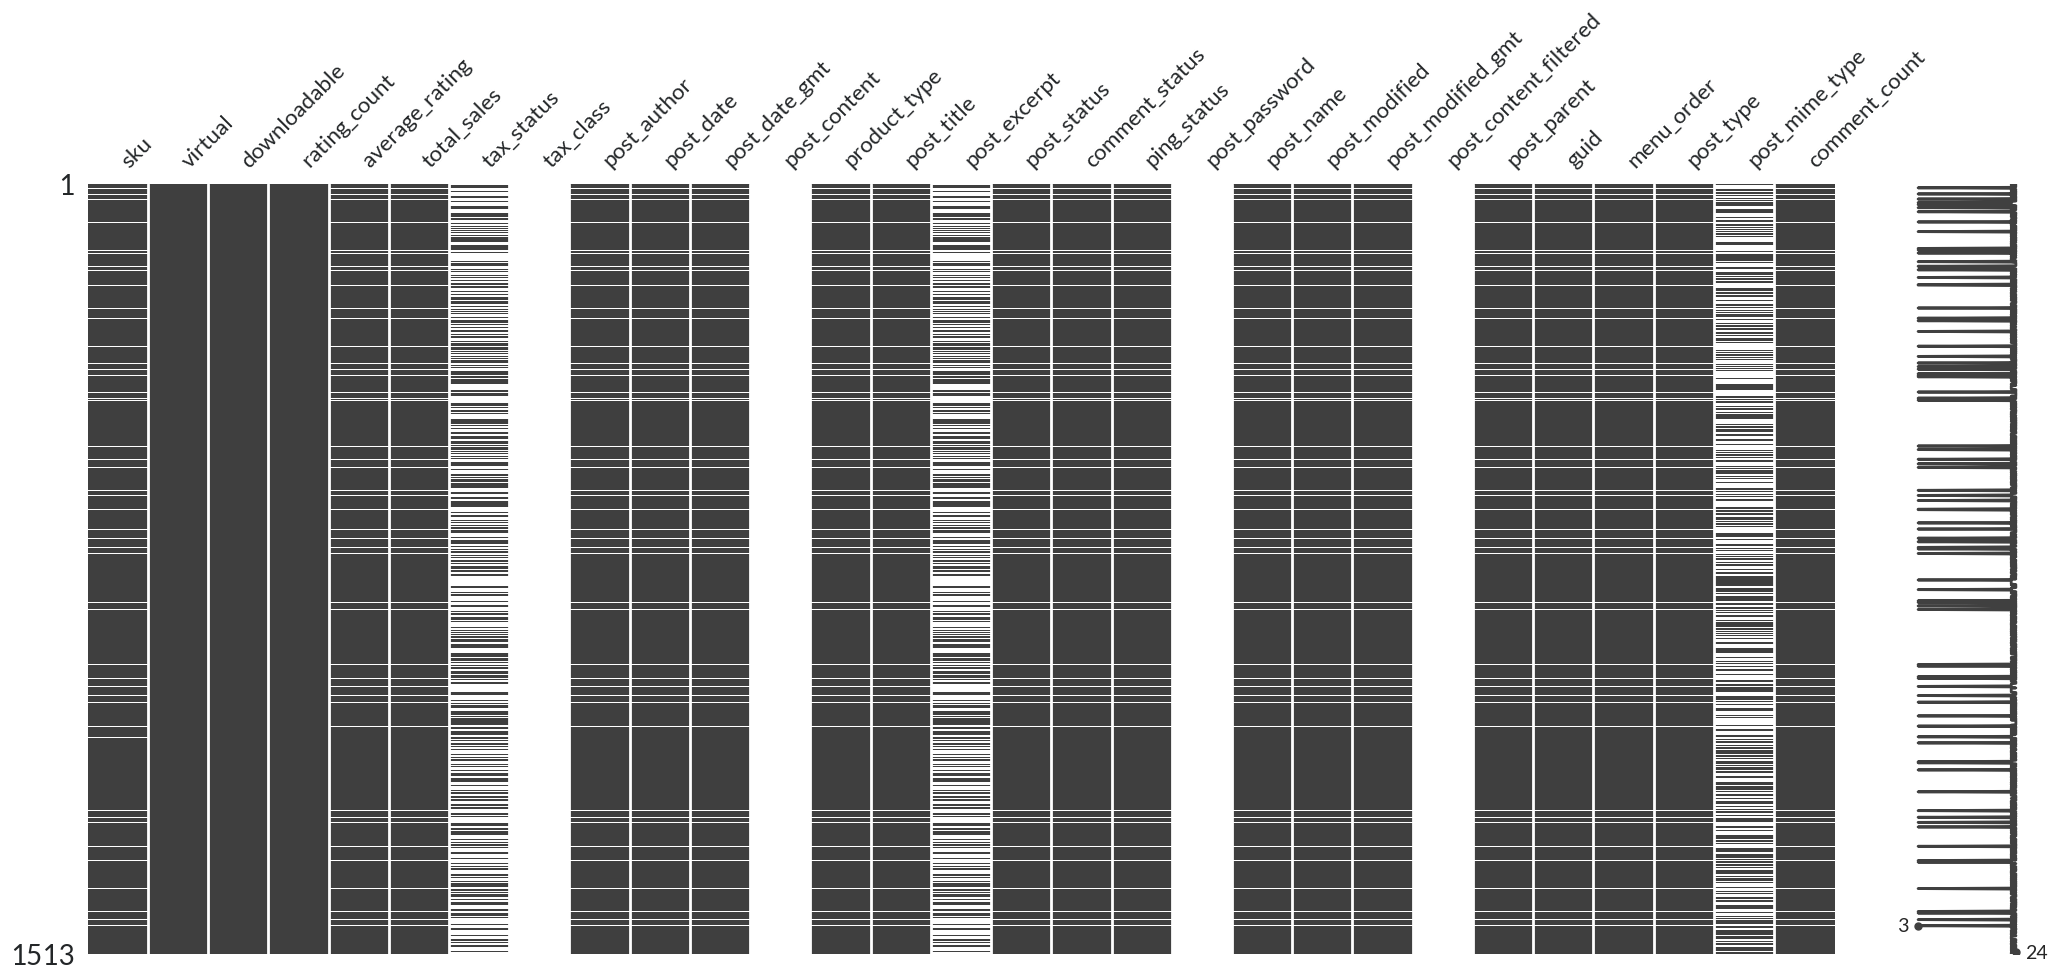

In [805]:
# Visualisation des données manquantes
msno.matrix(df_web)

In [806]:
df_web_info = description_variables(df_web)

# Créer une liste dont les colonnes possèdent plus de 50% de valeurs manquantes
missing_value_sup_50 = list(df_web_info.index[df_web_info['pourcentage_(NaN)'] > 50])

# Supprimer les 7 colonnes avec + de 50% de valeurs manquantes.
df_web = df_web.drop(missing_value_sup_50, axis=1)
df_web

Description donnée(s):
Le jeu de données comporte: 1513 observation(s)
Le jeu de données comporte: 29 colonne(s)


,sku,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count
0,11862,0,0,0,0.0,3.0,2.0,2018-02-12 13:46:23,2018-02-12 12:46:23,Vin,Gilles Robin Hermitage Rouge 2012,publish,closed,closed,gilles-robin-hermitage-2012,2019-01-31 12:12:56,2019-01-31 11:12:56,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
1,16057,0,0,0,0.0,5.0,2.0,2018-04-17 15:29:17,2018-04-17 13:29:17,Vin,Domaine Pellé Sancerre Rouge La Croix Au Garde...,publish,closed,closed,pelle-sancerre-rouge-la-croix-au-garde-2017,2020-07-07 10:05:02,2020-07-07 08:05:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
2,14692,0,0,0,0.0,5.0,2.0,2019-03-19 10:06:47,2019-03-19 09:06:47,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016,publish,closed,closed,fonreaud-bordeaux-blanc-le-cygne-2016,2020-04-25 21:40:31,2020-04-25 19:40:31,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
3,16295,0,0,0,0.0,14.0,2.0,2018-02-15 14:05:06,2018-02-15 13:05:06,Vin,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,publish,closed,closed,moulin-de-gassac-igp-pays-dherault-guilhem-ros...,2020-08-27 18:55:03,2020-08-27 16:55:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
4,15328,0,0,0,0.0,2.0,2.0,2019-03-27 18:05:09,2019-03-27 17:05:09,Vin,Agnès Levet Côte Rôtie Maestria 2017,publish,closed,closed,agnes-levet-cote-rotie-maestria-2017,2020-07-25 15:45:02,2020-07-25 13:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16326,0,0,0,0.0,5.0,2.0,2019-04-18 11:32:46,2019-04-18 09:32:46,Vin,Camin Larredya Jurançon Moelleux Au Capcéu 2018,publish,closed,closed,camin-larredya-jurancon-moelleux-capceu-2018,2020-08-27 09:24:46,2020-08-27 07:24:46,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
1509,15662,0,0,0,0.0,15.0,2.0,2018-02-27 10:13:03,2018-02-27 09:13:03,Vin,Chermette Domaine du Vissoux Beaujolais Griott...,publish,closed,closed,chermette-domaine-du-vissoux-beaujolais-griott...,2020-07-11 11:25:03,2020-07-11 09:25:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
1510,15329,0,0,0,0.0,3.0,2.0,2019-03-27 18:28:15,2019-03-27 17:28:15,Vin,Agnès Levet Côte Rôtie Péroline 2017,publish,closed,closed,agnes-levet-cote-rotie-peroline-2017,2020-07-28 09:45:02,2020-07-28 07:45:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
1511,14827,0,0,0,0.0,7.0,2.0,2018-11-26 09:56:52,2018-11-26 08:56:52,Vin,Marc Colin Et Fils Chassagne-Montrachet Blanc ...,publish,closed,closed,marc-colin-et-fils-chassagne-montrachet-blanc-...,2020-07-28 09:45:02,2020-07-28 07:45:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0


In [807]:
#Identifier les lignes sans code articles
sku_na = df_web['sku'].isna().sum()
print("Lignes sans codes articles: {}".format(sku_na))

Lignes sans codes articles: 85


In [808]:
#Identifier et afficher les lignes sans code articles
df_web_vide = df_web.loc[df_web["sku"].isna()]

print("Liste sans code(s) article(s):")
df_web_vide.head()

Liste sans code(s) article(s):


,sku,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count
8,NaN,0,0,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
20,NaN,0,0,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
30,NaN,0,0,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
37,NaN,0,0,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
41,NaN,0,0,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [809]:
description_variables(df_web_vide)

Description donnée(s):
Le jeu de données comporte: 85 observation(s)
Le jeu de données comporte: 22 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
sku,object,85,0,0,85,100.00
comment_status,object,85,2,1,83,97.65
post_type,object,85,2,1,83,97.65
menu_order,float64,85,2,1,83,97.65
guid,object,85,2,2,83,97.65
post_parent,float64,85,2,1,83,97.65
post_modified_gmt,datetime64[ns],85,2,2,83,97.65
post_modified,datetime64[ns],85,2,2,83,97.65
post_name,object,85,2,2,83,97.65
ping_status,object,85,2,1,83,97.65


In [810]:
statistiques_descriptives(df_web_vide)

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
virtual,85,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0
downloadable,85,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0
rating_count,85,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0
average_rating,2,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,NaN,NaN
total_sales,2,2,-56.0,-17.0,-36.5,-36.5,-46.25,19.5,-26.75,27.577164,760.5,NaN,NaN
post_author,2,1,2.0,2.0,2.0,2.0,2.00,0.0,2.00,0.000000,0.0,NaN,NaN
post_parent,2,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,NaN,NaN
menu_order,2,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,NaN,NaN
comment_count,2,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,NaN,NaN


In [811]:
# Suppression des valeurs manquantes
df_web.drop(df_web_vide.index, axis=0, inplace=True)
df_web.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1428 entries, 0 to 1512
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sku                1428 non-null   object        
 1   virtual            1428 non-null   int64         
 2   downloadable       1428 non-null   int64         
 3   rating_count       1428 non-null   int64         
 4   average_rating     1428 non-null   float64       
 5   total_sales        1428 non-null   float64       
 6   post_author        1428 non-null   float64       
 7   post_date          1428 non-null   datetime64[ns]
 8   post_date_gmt      1428 non-null   datetime64[ns]
 9   product_type       1427 non-null   object        
 10  post_title         1428 non-null   object        
 11  post_status        1428 non-null   object        
 12  comment_status     1428 non-null   object        
 13  ping_status        1428 non-null   object        
 14  post_name    

In [812]:
description_variables(df_web)

Description donnée(s):
Le jeu de données comporte: 1428 observation(s)
Le jeu de données comporte: 22 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_type,object,1428,1427,7,1,0.07
sku,object,1428,1428,714,0,0.00
comment_status,object,1428,1428,1,0,0.00
post_type,object,1428,1428,2,0,0.00
menu_order,float64,1428,1428,1,0,0.00
guid,object,1428,1428,1428,0,0.00
post_parent,float64,1428,1428,1,0,0.00
post_modified_gmt,datetime64[ns],1428,1428,587,0,0.00
post_modified,datetime64[ns],1428,1428,587,0,0.00
post_name,object,1428,1428,714,0,0.00


La colonne sku comporte 714 doublons

In [813]:
# Recoder la variable sku en str
df_web['sku'] = df_web['sku'].astype('str')

val_sku = df_web['sku'].duplicated(keep=False)

df_web.sort_values(by='sku').head(4)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count
668,10014,0,0,0,0.0,10.0,2.0,2019-04-04 15:45:23,2019-04-04 13:45:23,Gin,Darnley's London Dry Gin Original,publish,closed,closed,darnleys-london-dry-gin-original,2020-08-26 15:55:02,2020-08-26 13:55:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
1030,10014,0,0,0,0.0,10.0,2.0,2019-04-04 15:45:23,2019-04-04 13:45:23,Gin,Darnley's London Dry Gin Original,publish,closed,closed,darnleys-london-dry-gin-original,2020-08-26 15:55:02,2020-08-26 13:55:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
887,10459,0,0,0,0.0,4.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Vin,Alphonse Mellot Sancerre Rouge Génération XIX ...,publish,closed,closed,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
748,10459,0,0,0,0.0,4.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Vin,Alphonse Mellot Sancerre Rouge Génération XIX ...,publish,closed,closed,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0


In [814]:
df_web['post_type'].value_counts()

post_type
attachment    714
product       714
Name: count, dtype: int64

On observe que les doublons se trouvent au sein de la colonne post_type

Cette colonne possède 2 modalités product et attachment avec respectivement 714 valeurs

In [815]:
# Filtrer et afficher le dataframe avec uniquement la valeur attachment
post_type_doublons = df_web.loc[df_web['post_type'] =='attachment', :]
post_type_doublons

,sku,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count
0,11862,0,0,0,0.0,3.0,2.0,2018-02-12 13:46:23,2018-02-12 12:46:23,Vin,Gilles Robin Hermitage Rouge 2012,publish,closed,closed,gilles-robin-hermitage-2012,2019-01-31 12:12:56,2019-01-31 11:12:56,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
1,16057,0,0,0,0.0,5.0,2.0,2018-04-17 15:29:17,2018-04-17 13:29:17,Vin,Domaine Pellé Sancerre Rouge La Croix Au Garde...,publish,closed,closed,pelle-sancerre-rouge-la-croix-au-garde-2017,2020-07-07 10:05:02,2020-07-07 08:05:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
3,16295,0,0,0,0.0,14.0,2.0,2018-02-15 14:05:06,2018-02-15 13:05:06,Vin,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,publish,closed,closed,moulin-de-gassac-igp-pays-dherault-guilhem-ros...,2020-08-27 18:55:03,2020-08-27 16:55:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
5,15471,0,0,0,0.0,4.0,2.0,2019-03-19 15:58:25,2019-03-19 14:58:25,Vin,Château d'Arcole Saint-Emilion Grand Cru 2016,publish,closed,closed,arcole-saint-emilion-grand-cru-2016,2020-06-18 10:45:05,2020-06-18 08:45:05,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
7,16246,0,0,0,0.0,10.0,2.0,2018-02-28 14:46:15,2018-02-28 13:46:15,Vin,Domaine de La Tour Du Bon Bandol Blanc 2019,publish,closed,closed,la-tour-du-bon-bandol-blanc-2019,2020-08-26 15:55:03,2020-08-26 13:55:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,15748,0,0,0,0.0,9.0,2.0,2018-11-26 10:57:23,2018-11-26 09:57:23,Vin,Tempier Bandol Rouge 2017,publish,closed,closed,tempier-bandol-2017,2020-08-26 17:15:02,2020-08-26 15:15:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
1506,16261,0,0,0,0.0,7.0,2.0,2018-04-17 09:37:34,2018-04-17 07:37:34,Vin,Bernard Baudry Chinon Blanc 2018,publish,closed,closed,bernard-baudry-chinon-blanc-2018,2020-07-11 17:05:06,2020-07-11 15:05:06,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
1510,15329,0,0,0,0.0,3.0,2.0,2019-03-27 18:28:15,2019-03-27 17:28:15,Vin,Agnès Levet Côte Rôtie Péroline 2017,publish,closed,closed,agnes-levet-cote-rotie-peroline-2017,2020-07-28 09:45:02,2020-07-28 07:45:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0
1511,14827,0,0,0,0.0,7.0,2.0,2018-11-26 09:56:52,2018-11-26 08:56:52,Vin,Marc Colin Et Fils Chassagne-Montrachet Blanc ...,publish,closed,closed,marc-colin-et-fils-chassagne-montrachet-blanc-...,2020-07-28 09:45:02,2020-07-28 07:45:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,0.0


In [816]:
# Supprimer les doublons
df_web.drop(post_type_doublons.index, axis=0, inplace=True)
df_web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count
2,14692,0,0,0,0.0,5.0,2.0,2019-03-19 10:06:47,2019-03-19 09:06:47,Vin,Château Fonréaud Bordeaux Blanc Le Cygne 2016,publish,closed,closed,fonreaud-bordeaux-blanc-le-cygne-2016,2020-04-25 21:40:31,2020-04-25 19:40:31,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
4,15328,0,0,0,0.0,2.0,2.0,2019-03-27 18:05:09,2019-03-27 17:05:09,Vin,Agnès Levet Côte Rôtie Maestria 2017,publish,closed,closed,agnes-levet-cote-rotie-maestria-2017,2020-07-25 15:45:02,2020-07-25 13:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
6,16515,0,0,0,0.0,10.0,2.0,2018-06-02 09:31:31,2018-06-02 07:31:31,Vin,Château Turcaud Bordeaux Rouge Cuvée Majeure 2018,publish,closed,closed,chateau-turcaud-bordeaux-rouge-cuvee-majeure-2018,2020-08-27 10:11:12,2020-08-27 08:11:12,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
11,16585,0,0,0,0.0,15.0,2.0,2018-02-16 14:03:16,2018-02-16 13:03:16,Vin,Xavier Frissant Touraine Sauvignon 2019,publish,closed,closed,xavier-frissant-touraine-sauvignon-2019,2020-08-27 09:30:36,2020-08-27 07:30:36,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
14,12869,0,0,0,0.0,7.0,2.0,2019-03-28 14:29:35,2019-03-28 13:29:35,Vin,Stéphane Tissot Arbois D.D. 2016,publish,closed,closed,stephane-tissot-arbois-dd-2016,2019-12-13 15:40:01,2019-12-13 14:40:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,13074,0,0,0,0.0,4.0,2.0,2018-02-12 14:25:28,2018-02-12 13:25:28,Vin,Château de Vaudieu Châteauneuf-du-Pape L'Avenu...,publish,closed,closed,chateau-de-vaudieu-chateauneuf-du-pape-lavenue...,2019-12-09 10:40:03,2019-12-09 09:40:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
1505,16322,0,0,0,0.0,0.0,2.0,2018-02-15 13:51:32,2018-02-15 12:51:32,Vin,Moulin de Gassac IGP Pays d'Hérault Guilhem Ro...,publish,closed,closed,moulin-gassac-igp-pays-herault-guilhem-rouge-2019,2020-08-26 16:05:03,2020-08-26 14:05:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
1507,12365,0,0,0,0.0,10.0,2.0,2019-01-29 15:53:05,2019-01-29 14:53:05,Vin,Parés Baltà Penedès Electio 2013,publish,closed,closed,pares-balta-penedes-electio-2013,2020-08-08 17:45:02,2020-08-08 15:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0
1508,16326,0,0,0,0.0,5.0,2.0,2019-04-18 11:32:46,2019-04-18 09:32:46,Vin,Camin Larredya Jurançon Moelleux Au Capcéu 2018,publish,closed,closed,camin-larredya-jurancon-moelleux-capceu-2018,2020-08-27 09:24:46,2020-08-27 07:24:46,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0


In [817]:
# Vérifier la suppression des valeurs en double: attachment
df_web['post_type'].value_counts()

post_type
product    714
Name: count, dtype: int64

<Axes: >

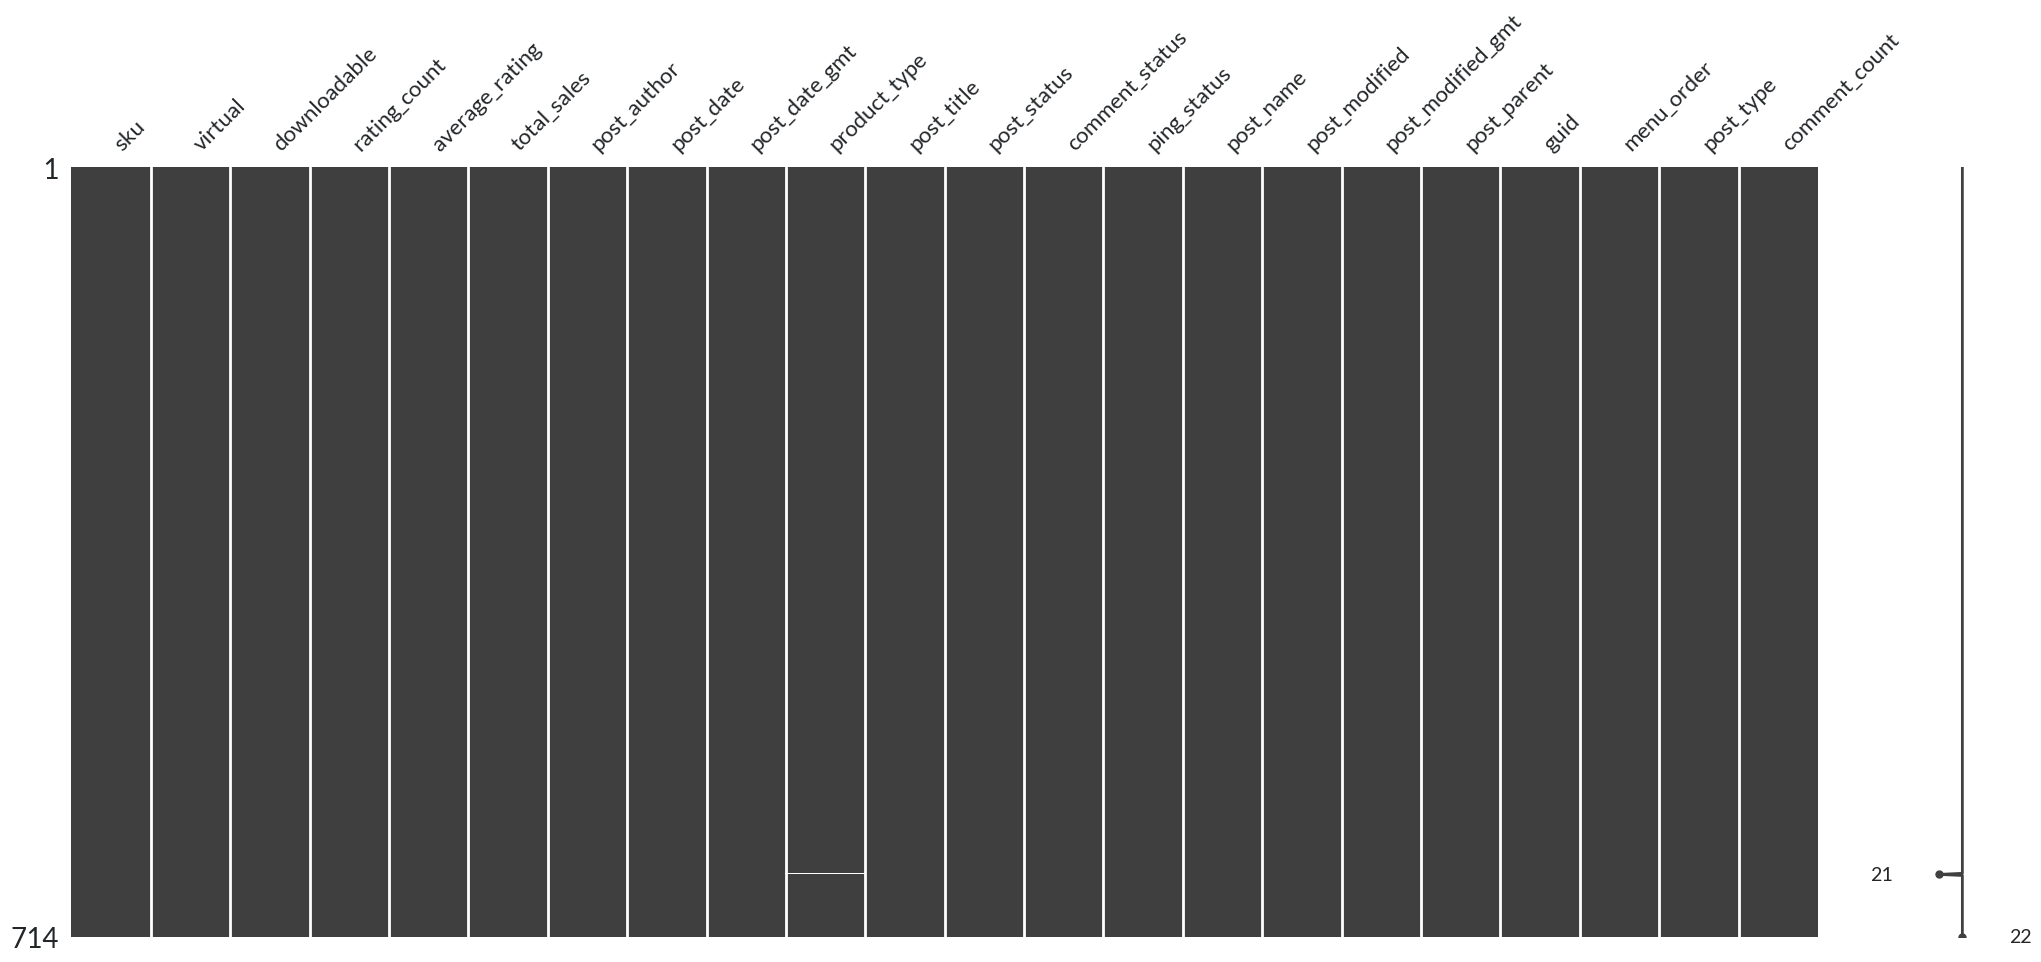

In [818]:
# Visualiser les données manquantes
msno.matrix(df_web)

In [819]:
#Identifier les lignes product_type: NaN
product_type_nan = df_web.loc[df_web["product_type"].isna()]
product_type_nan


,sku,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count
1387,bon-cadeau-25-euros,0,0,0,0.0,7.0,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,publish,closed,closed,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0


Cette ligne est conservée

In [820]:
description_variables(df_web)

Description donnée(s):
Le jeu de données comporte: 714 observation(s)
Le jeu de données comporte: 22 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_type,object,714,713,6,1,0.14
sku,object,714,714,714,0,0.00
comment_status,object,714,714,1,0,0.00
post_type,object,714,714,1,0,0.00
menu_order,float64,714,714,1,0,0.00
guid,object,714,714,714,0,0.00
post_parent,float64,714,714,1,0,0.00
post_modified_gmt,datetime64[ns],714,714,587,0,0.00
post_modified,datetime64[ns],714,714,587,0,0.00
post_name,object,714,714,714,0,0.00


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.3 - Analyse exploratoire du fichier liaison.xlsx</h3>
</div>

In [821]:
description_variables(df_liaison)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 2 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
id_web,object,825,734,734,91,11.03
product_id,int64,825,825,825,0,0.00


In [822]:
# Afficher les 5 premières lignes
df_liaison.head()

,id_web,product_id
0,15298,3847
1,15296,3849
2,15300,3850
3,19814,4032
4,19815,4039


<Axes: >

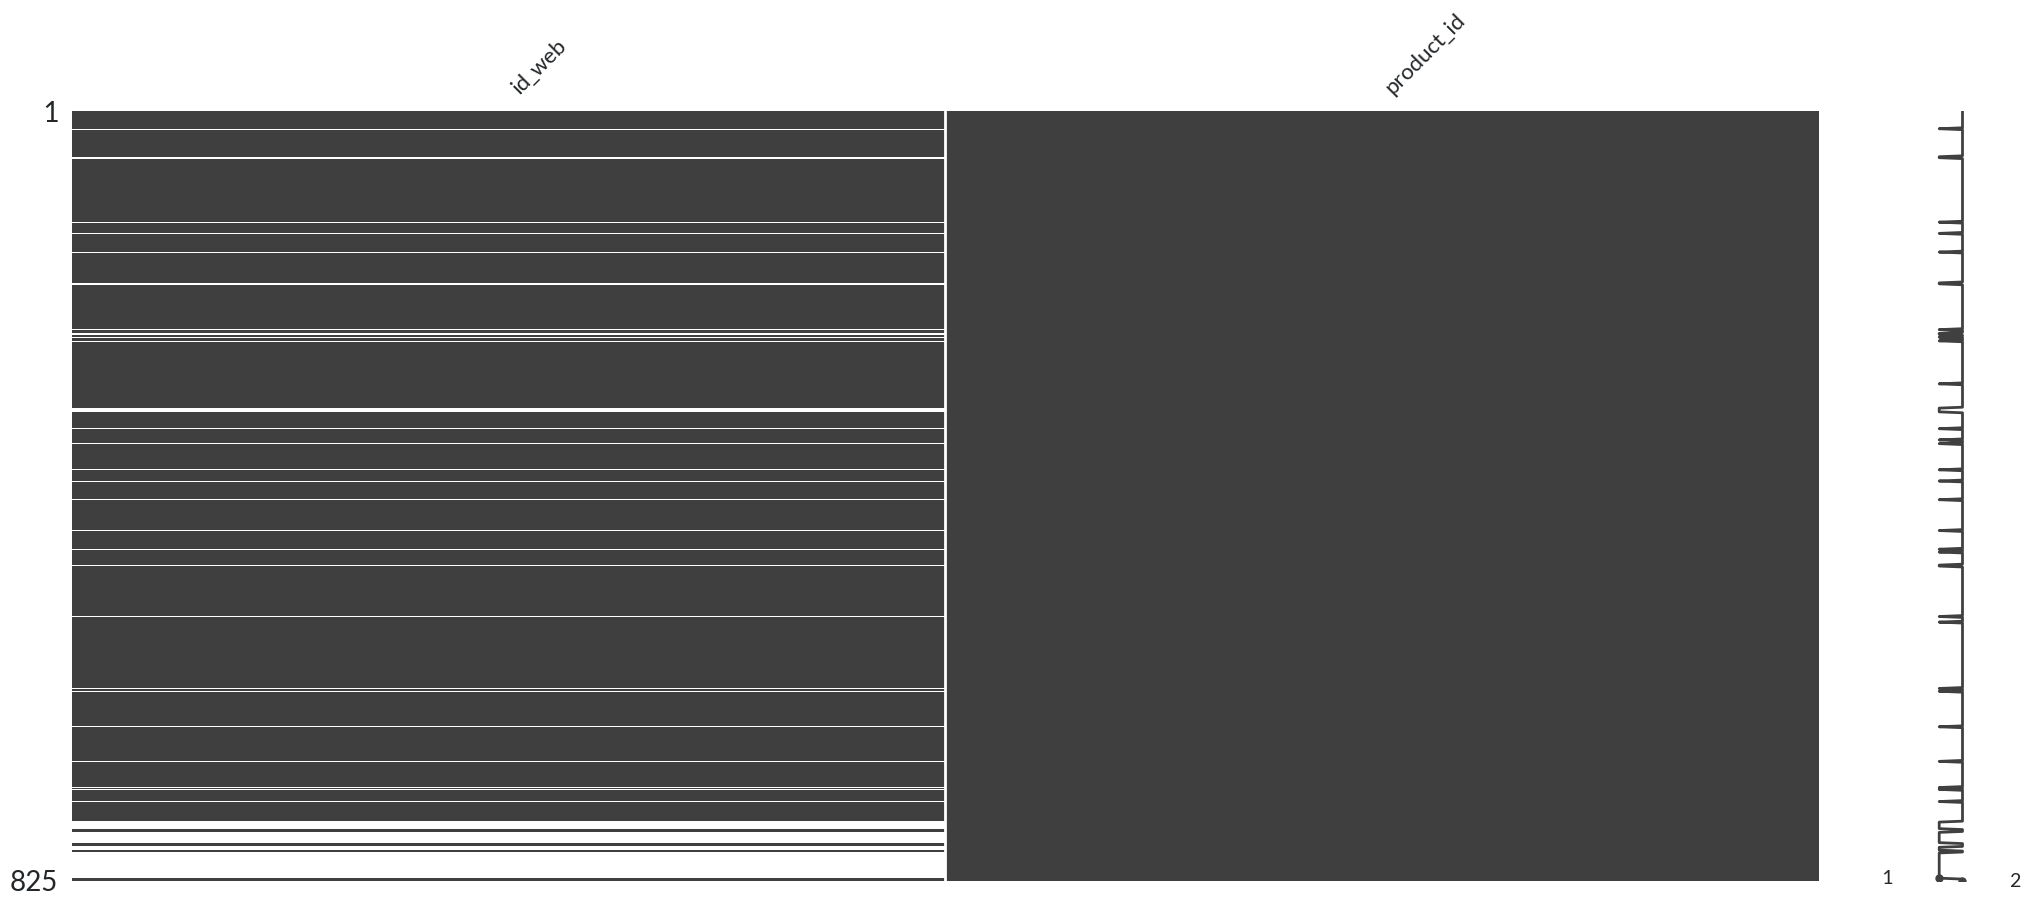

In [823]:
# Visualiser les données manquantes
msno.matrix(df_liaison)

* **product_id** dispose de données uniques sans valeurs manquantes
* **id_web** dispose de 734 données uniques et 91 valeurs manquantes par conséquence sans correspondance
* **id_web** est un object, il semble que cette colonne possède éventuellement des données alphanumériques.

In [824]:
# Modifier le type de la variable id_web en str
df_liaison.id_web = df_liaison.id_web.astype('str')

# Afficher les valeurs 
df_liaison.loc[df_liaison['id_web']== 'nan']

,id_web,product_id
19,nan,4055
49,nan,4090
50,nan,4092
119,nan,4195
131,nan,4209
...,...,...
817,nan,7196
818,nan,7200
819,nan,7201
820,nan,7203


In [825]:
# Remplacer nan par NaN
df_liaison.loc[df_liaison['id_web'] == 'nan', 'id_web'] = 'NaN'

# Vérifier le remplacement
df_liaison.loc[df_liaison['id_web']== 'nan']

,id_web,product_id


In [826]:
df_liaison.sort_values(by='id_web', ascending=False, inplace=True)
df_liaison

,id_web,product_id
443,bon-cadeau-25-euros,4954
246,NaN,4599
805,NaN,7159
799,NaN,7088
800,NaN,7131
...,...,...
265,11049,4619
289,10814,4656
329,10775,4709
263,10459,4617


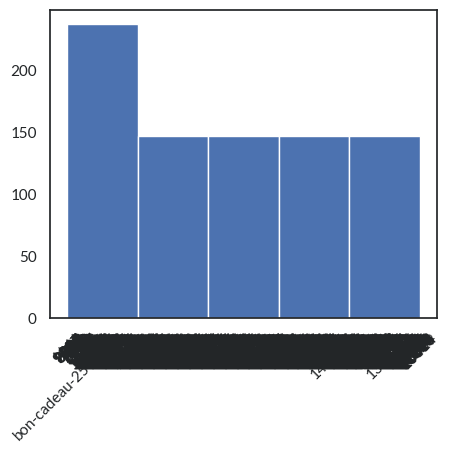

In [827]:
# Histogramme
plt.figure(figsize = (5,4))
df_liaison["id_web"].hist(bins=5)
plt.xticks(rotation=45)
plt.show()

* id_web possède des données alphanumériques (bon-cadeau-25-euros)
* Les données nan ont été remplacées par NaN

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Jonction des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.1 - Jonction du fichier df_erp et df_liaison</h3>
</div>

In [828]:
# Renommer la colonne id_web de la table liaison correspondant à 'sku' dans la table web
df_liaison=df_liaison.rename(columns={'id_web':'sku'})

In [829]:
# Fusion des fichiers df_erp et df_liaison
df_merge = pd.merge(df_erp, df_liaison, on='product_id', how = 'outer', indicator=True)

In [830]:
# Contrôler la qualité des jointures
df_merge._merge.value_counts()

_merge
both          825
left_only       0
right_only      0
Name: count, dtype: int64

In [831]:
# Afficher les lignes qui n'ont pas matché
df_merge[df_merge['_merge'] == 'right_only']

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,_merge


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.2 - Jonction du fichier df_merge et df_web</h3>
</div>

In [832]:
description_variables(df_merge)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 8 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
price,float64,825,822,380,3,0.36
stock_quantity,float64,825,823,82,2,0.24
product_id,int64,825,825,825,0,0.00
onsale_web,category,825,825,2,0,0.00
purchase_price,float64,825,825,660,0,0.00
stock_status_2,object,825,825,2,0,0.00
sku,object,825,825,735,0,0.00
_merge,category,825,825,1,0,0.00


In [833]:
df_merge.sku = df_merge.sku.astype('str')

In [834]:
description_variables(df_web)

Description donnée(s):
Le jeu de données comporte: 714 observation(s)
Le jeu de données comporte: 22 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_type,object,714,713,6,1,0.14
sku,object,714,714,714,0,0.00
comment_status,object,714,714,1,0,0.00
post_type,object,714,714,1,0,0.00
menu_order,float64,714,714,1,0,0.00
guid,object,714,714,714,0,0.00
post_parent,float64,714,714,1,0,0.00
post_modified_gmt,datetime64[ns],714,714,587,0,0.00
post_modified,datetime64[ns],714,714,587,0,0.00
post_name,object,714,714,714,0,0.00


In [835]:
# Renommer _merge pour réaliser la 2ème jointure avec outer indicator=true
df_merge.rename(columns={'_merge': 'df1_merge'}, inplace=True)

#Fusionnez les datasets df_merge et df_web
df_final = pd.merge(df_merge, df_web, on='sku', how='outer', indicator=True)

In [836]:
# Contrôler la qualité des jointures
df_final._merge.value_counts()

_merge
both          714
left_only     111
right_only      0
Name: count, dtype: int64

In [837]:
# Afficher les lignes qui n'ont pas matché
df_final[df_final['_merge'] == 'left_only']

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge
40,4741,0,12.4,0.0,6.66,outofstock,12601,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
87,5957,0,39.0,0.0,20.75,outofstock,13577,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
102,4289,0,22.8,0.0,11.90,outofstock,13771,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
143,4869,0,17.2,0.0,9.33,outofstock,14360,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
148,5955,0,27.3,0.0,13.68,outofstock,14377,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only


In [838]:
description_variables(df_final)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 30 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_type,object,825,713,6,112,13.58
post_date_gmt,datetime64[ns],825,714,714,111,13.45
total_sales,float64,825,714,24,111,13.45
post_name,object,825,714,714,111,13.45
ping_status,object,825,714,1,111,13.45
comment_status,object,825,714,1,111,13.45
post_status,object,825,714,1,111,13.45
post_title,object,825,714,711,111,13.45
post_parent,float64,825,714,1,111,13.45
post_date,datetime64[ns],825,714,714,111,13.45


<Axes: >

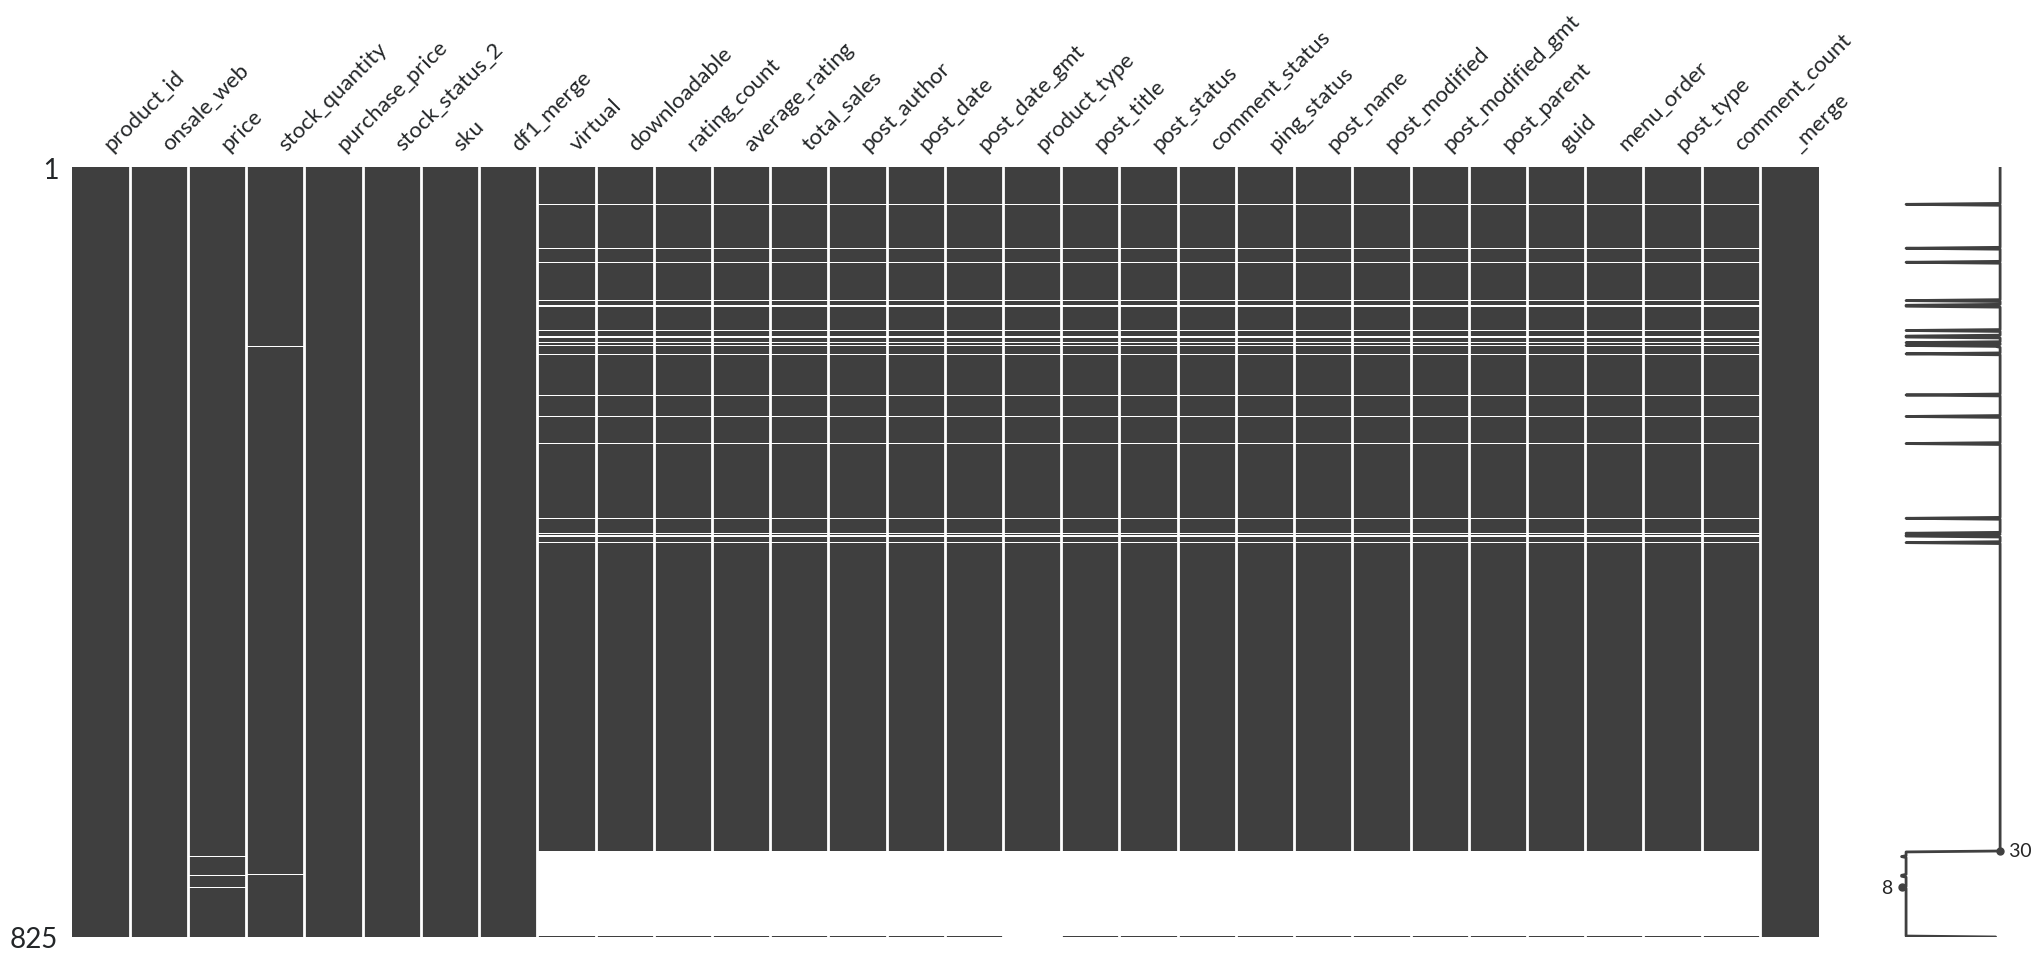

In [839]:
# Visualiser les données manquantes
msno.matrix(df_final)


<Axes: >

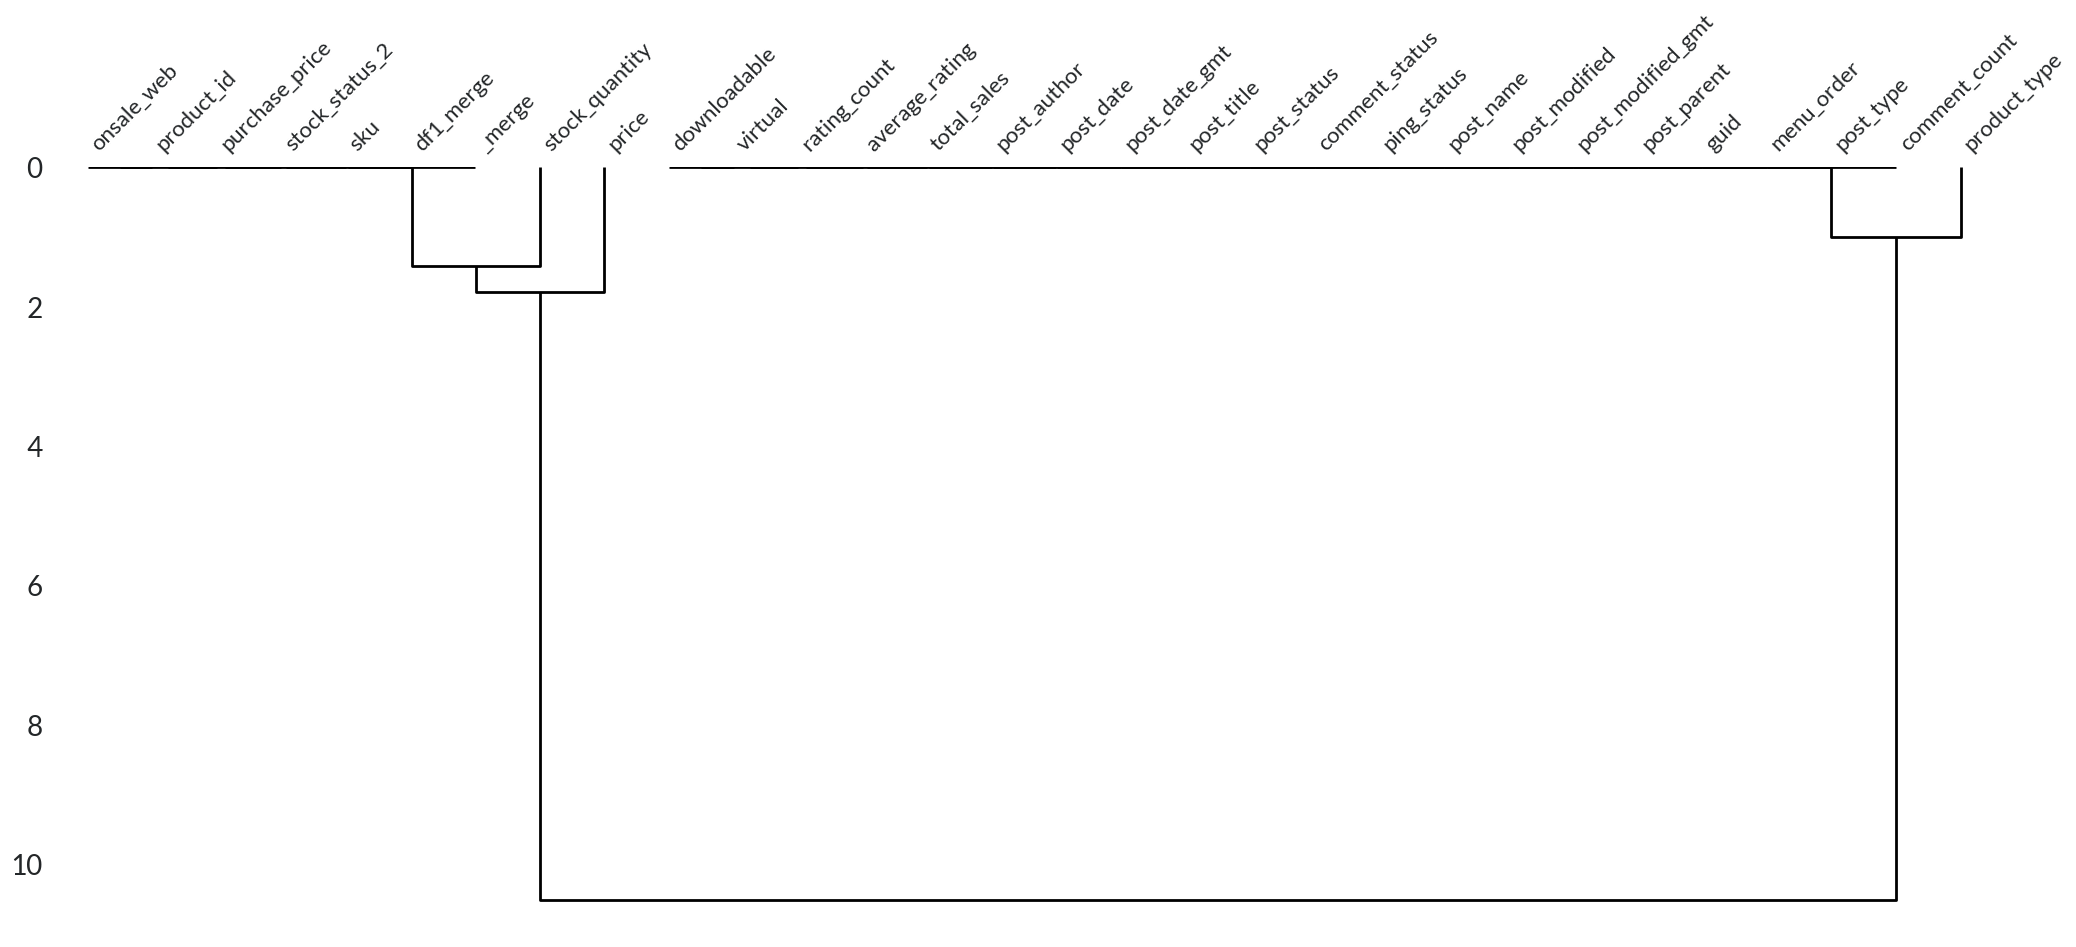

In [840]:
msno.dendrogram(df_final)

In [841]:
description_variables(df_final)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 30 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
product_type,object,825,713,6,112,13.58
post_date_gmt,datetime64[ns],825,714,714,111,13.45
total_sales,float64,825,714,24,111,13.45
post_name,object,825,714,714,111,13.45
ping_status,object,825,714,1,111,13.45
comment_status,object,825,714,1,111,13.45
post_status,object,825,714,1,111,13.45
post_title,object,825,714,711,111,13.45
post_parent,float64,825,714,1,111,13.45
post_date,datetime64[ns],825,714,714,111,13.45


<Axes: >

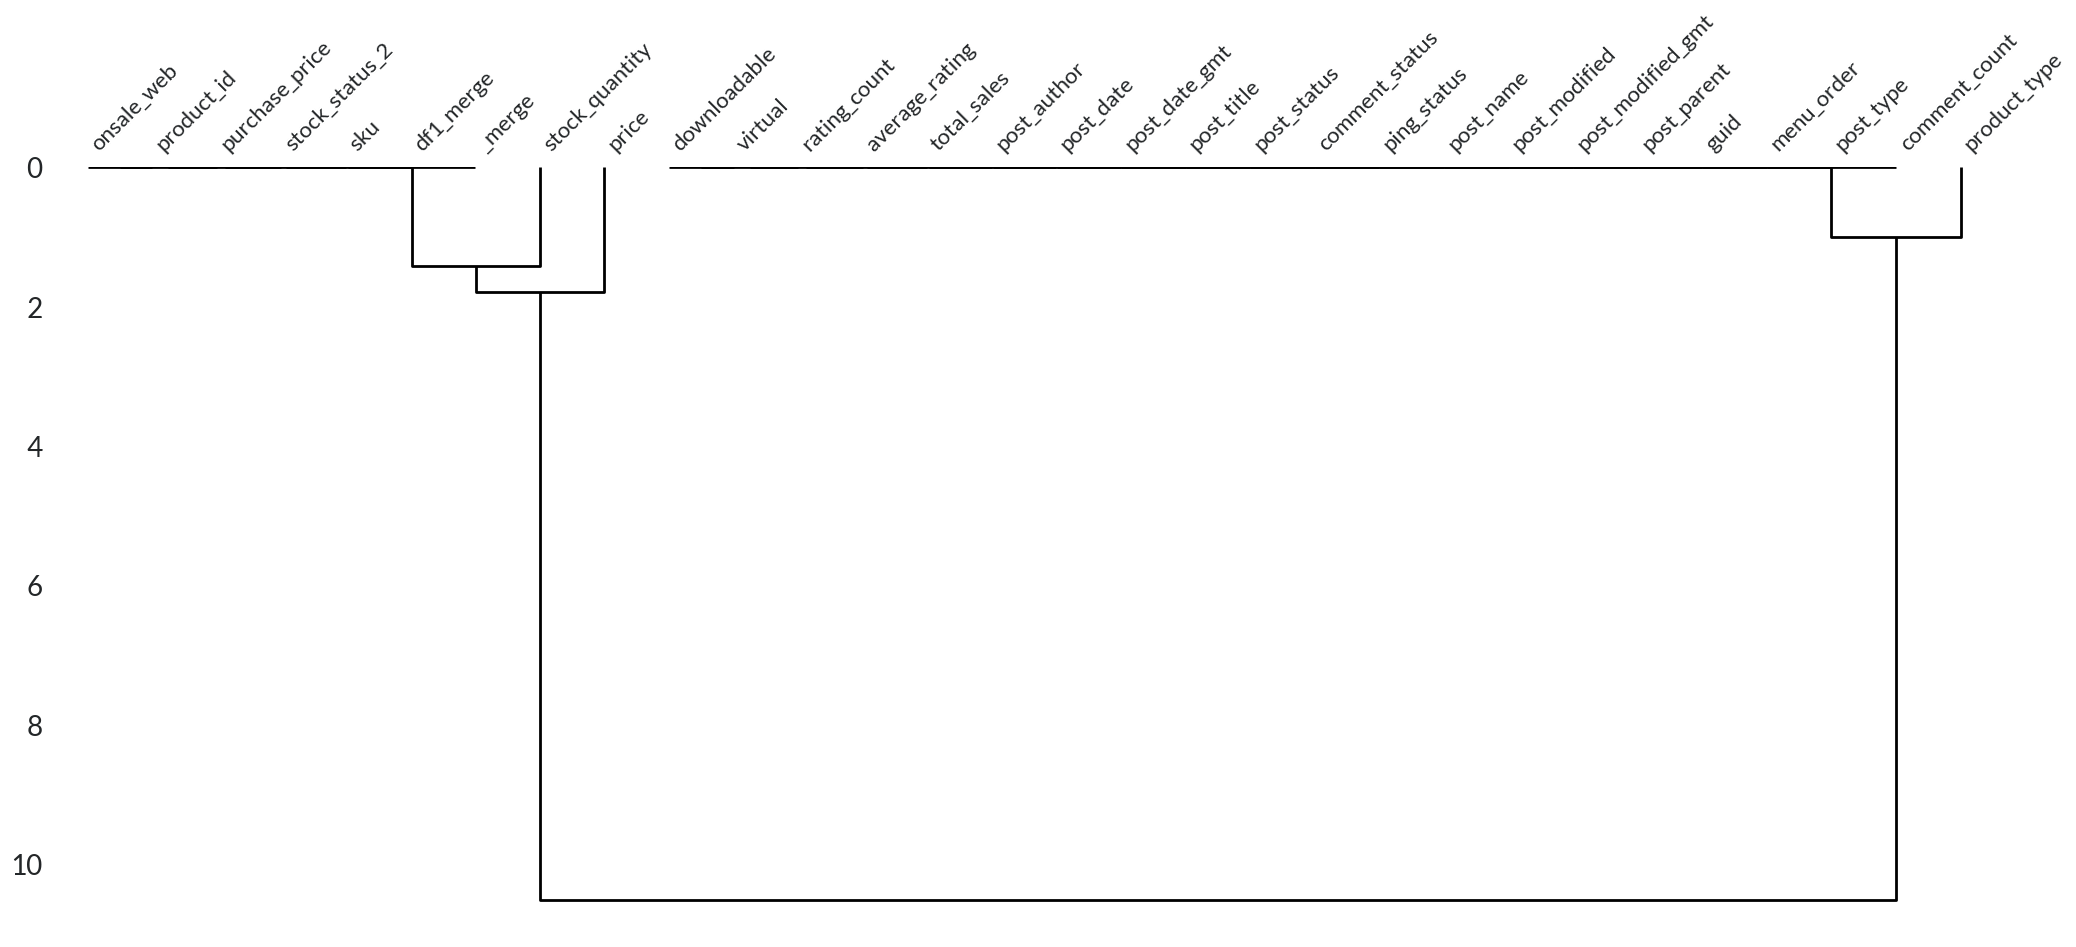

In [842]:
msno.dendrogram(df_final)

In [843]:
# Afficher un dataframe avec les données manquantes de la colonne post_type
df_final[df_final['post_type'].isna()]

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge
40,4741,0,12.4,0.0,6.66,outofstock,12601,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
87,5957,0,39.0,0.0,20.75,outofstock,13577,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
102,4289,0,22.8,0.0,11.90,outofstock,13771,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
143,4869,0,17.2,0.0,9.33,outofstock,14360,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
148,5955,0,27.3,0.0,13.68,outofstock,14377,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyse univarié des prix</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.1 - Exploration par la visualisation de données</h3>
</div>

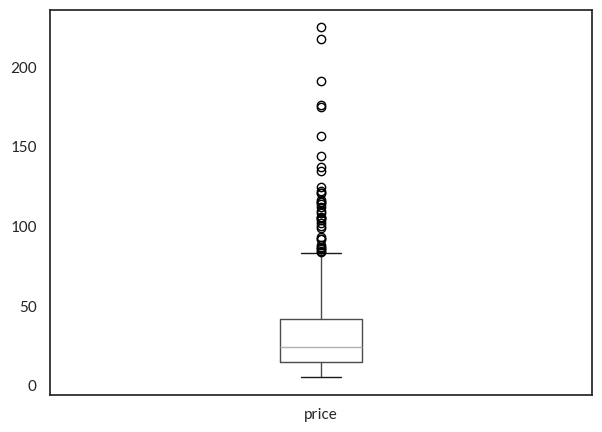

In [844]:
#Création d'une Boite à moustache de la répartition des prix grâce à Pandas
pandas_boxplot = df_final.boxplot(column=['price'], grid=False) 

In [845]:
#Autre méthode avec plotly express
graph1 = px.box(df_final, y="price",
title = "Répartition des prix de vente" , width = 400,  height = 500,)
graph1.update_traces(marker_color='#C00000', orientation= 'v')
template = "simple_white" 
graph1.show()

Text(0.5, 1.0, 'Histogramme de la variable prix')

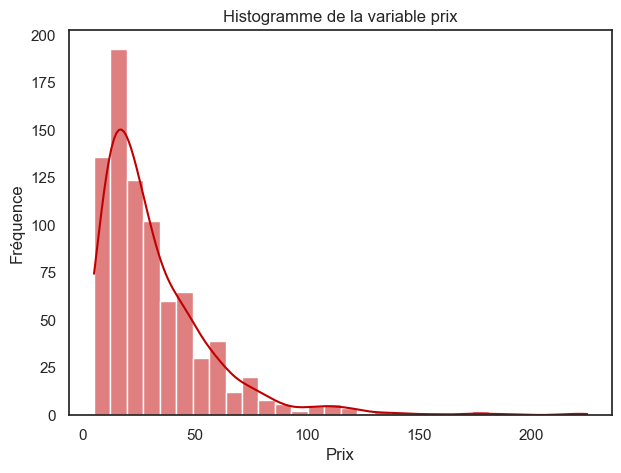

In [846]:
# Création de l'histogramme univarié de la variable price
sns.set_theme(style="white")
# Création de la figure et des axes
fig, histplot_price = plt.subplots()
histplot_price = sns.histplot(df_final['price'], bins=30, kde=True, color='#C00000')

# Personnalisation des axes
histplot_price.set_xlabel('Prix')
histplot_price.set_ylabel('Fréquence')
histplot_price.set_title('Histogramme de la variable prix')

In [847]:
# Sauvegarde du graphique
fig.savefig("distribution_prix.png")

In [848]:
statistiques_descriptives(df_final['price'])

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
price,822,380,5.2,225.0,32.350304,24.4,14.6,27.4,42.0,26.622453,708.755009,2.639051,10.858613


Une distribution asymétrique à droite, également appelée distribution asymétrique positive, est un type de distribution de probabilité dans lequel la queue du côté droit (valeurs les plus élevées) est plus longue ou plus épaisse que celle du côté gauche.

* Skewness = 2,63
* Kurtosis = 10,85

Caractéristiques d'une distribution asymétrique à droite :

* La moyenne est généralement supérieure à la médiane.
* La queue sur le côté droit est plus longue et contient souvent des valeurs aberrantes.
* La majorité des points de données se trouvent sur le côté gauche.

La distribution ne suit pas une loi normale.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.2 - Exploration par l'utisation de méthodes statistique</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.2.1 - Identification par le Z-index</h3>
</div>

In [849]:
#Calculer la moyenne du prix
mean_val = df_final['price'].mean()
mean_val

32.350304136253044

In [850]:
#Calculer l'écart-type du prix
std_val = df_final['price'].std()
std_val


26.62245309964109

In [851]:
# Calculer le z-score
df_final['zscore'] = (df_final['price'] - mean_val) / std_val
df_final['zscore']

0      0.137091
1      1.320303
2      0.437589
3      0.400027
4      1.001023
         ...   
820   -0.050721
821   -0.050721
822    0.475151
823    0.475151
824   -0.276094
Name: zscore, Length: 825, dtype: float64

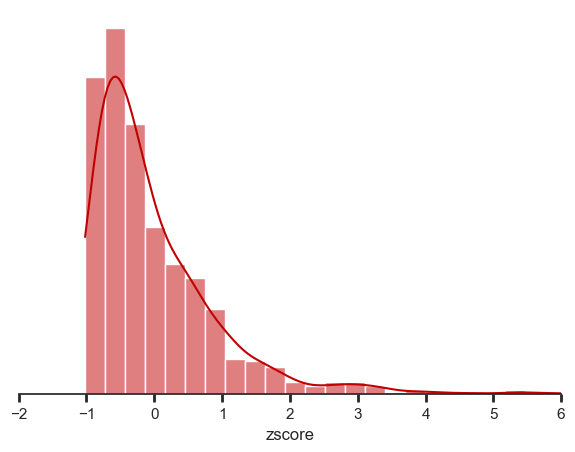

In [852]:
# Création de la figure et des axes
fig, ax = plt.subplots()


# Graphique du zscore avec histogramme rouge
sns.histplot(df_final, x='zscore', color='#C00000', kde=True, ax=ax, binwidth=0.3)


# Personnalisation du style Seaborn sans quadrillage
sns.set_style("white")

# Suppression de l'axe des ordonnées
ax.yaxis.set_visible(False)

# Suppression de l'axe des ordonnées
ax.yaxis.set_visible(False)

# Suppression des bordures supérieures et droites
sns.despine(left=True)

# Ajout des graduations sur l'axe des abscisses
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', direction='out', length=6, width=2)

ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='y', direction='out', length=6, width=2)

# Définir les limites de l'axe des abscisses
ax.set_xlim(-2, 6)
ax.set_xlabel('zscore')

# Affichage du graphique
plt.show()

# Sauvegarde du graphique
fig.savefig("zscore.png")

In [853]:
#Quel est le seuil prix dont z-score est supérieur à 3?
zscore_sup_3 = df_final.loc[df_final['zscore'] > 3]
zscore_sup_3.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore
46,6215,1,115.0,14.0,56.45,instock,12790,both,0.0,0.0,0.0,0.0,4.0,2.0,2019-07-25 09:30:16,2019-07-25 07:30:16,Vin,Domaine des Comtes Lafon Volnay 1er Cru Champa...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-champa...,2019-11-04 09:30:25,2019-11-04 08:30:25,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511
120,6212,1,115.0,16.0,59.42,instock,13996,both,0.0,0.0,0.0,0.0,7.0,2.0,2019-07-25 09:09:17,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-16 09:30:16,2020-06-16 07:30:16,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511
134,4904,1,137.0,9.0,67.95,instock,14220,both,0.0,0.0,0.0,0.0,3.0,2.0,2018-05-15 10:23:41,2018-05-15 08:23:41,Vin,Domaine Des Croix Corton Charlemagne Grand Cru...,publish,closed,closed,domaine-des-croix-corton-charlemagne-grand-cru...,2020-05-19 17:15:02,2020-05-19 15:15:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.930881
167,5001,1,217.5,18.0,116.87,instock,14581,both,0.0,0.0,0.0,0.0,2.0,2.0,2018-07-17 09:45:39,2018-07-17 07:45:39,Vin,David Duband Charmes-Chambertin Grand Cru 2014,publish,closed,closed,david-duband-charmes-chambertin-grand-cru-2014,2020-05-16 09:00:05,2020-05-16 07:00:05,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,6.954644
197,5918,1,114.0,12.0,52.25,instock,14773,both,0.0,0.0,0.0,0.0,3.0,2.0,2019-04-04 17:01:54,2019-04-04 15:01:54,Whisky,Wemyss Malts Single Cask Scotch Whisky Chai Ca...,publish,closed,closed,wemyss-malts-single-cask-scotch-whisky-chai-ca...,2020-07-31 18:25:03,2020-07-31 16:25:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.066949


In [854]:
zscore_sup_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 46 to 744
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         17 non-null     int64         
 1   onsale_web         17 non-null     category      
 2   price              17 non-null     float64       
 3   stock_quantity     17 non-null     float64       
 4   purchase_price     17 non-null     float64       
 5   stock_status_2     17 non-null     object        
 6   sku                17 non-null     object        
 7   df1_merge          17 non-null     category      
 8   virtual            16 non-null     float64       
 9   downloadable       16 non-null     float64       
 10  rating_count       16 non-null     float64       
 11  average_rating     16 non-null     float64       
 12  total_sales        16 non-null     float64       
 13  post_author        16 non-null     float64       
 14  post_date      

In [855]:
#Quel est le seuil prix dont z-score est supérieur à 2 ?
zscore_sup_2 = df_final.loc[df_final['zscore'] > 2]
zscore_sup_2.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore
12,6214,1,99.0,9.0,49.62,instock,11601,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-07-25 09:15:41,2019-07-25 07:15:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Champa...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-champa...,2020-07-04 11:35:02,2020-07-04 09:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.503514
13,5008,1,105.0,12.0,56.42,instock,11602,both,0.0,0.0,0.0,0.0,7.0,2.0,2018-07-17 10:52:41,2018-07-17 08:52:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-23 15:35:02,2020-06-23 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.728888
15,4132,1,88.4,7.0,44.30,instock,11668,both,0.0,0.0,0.0,0.0,5.0,2.0,2018-02-13 11:43:55,2018-02-13 10:43:55,Vin,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,publish,closed,closed,zind-humbrecht-pinot-gris-grand-cru-rangen-de-...,2020-02-20 09:55:02,2020-02-20 08:55:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.105354
46,6215,1,115.0,14.0,56.45,instock,12790,both,0.0,0.0,0.0,0.0,4.0,2.0,2019-07-25 09:30:16,2019-07-25 07:30:16,Vin,Domaine des Comtes Lafon Volnay 1er Cru Champa...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-champa...,2019-11-04 09:30:25,2019-11-04 08:30:25,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511
47,5007,1,105.0,15.0,55.88,instock,12791,both,0.0,0.0,0.0,0.0,3.0,2.0,2018-07-17 10:36:03,2018-07-17 08:36:03,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-07-02 09:30:03,2020-07-02 07:30:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.728888


In [856]:
zscore_sup_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 12 to 769
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         34 non-null     int64         
 1   onsale_web         34 non-null     category      
 2   price              34 non-null     float64       
 3   stock_quantity     34 non-null     float64       
 4   purchase_price     34 non-null     float64       
 5   stock_status_2     34 non-null     object        
 6   sku                34 non-null     object        
 7   df1_merge          34 non-null     category      
 8   virtual            31 non-null     float64       
 9   downloadable       31 non-null     float64       
 10  rating_count       31 non-null     float64       
 11  average_rating     31 non-null     float64       
 12  total_sales        31 non-null     float64       
 13  post_author        31 non-null     float64       
 14  post_date      

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.2.2 - Identification par l'interval interquartile</h3>
</div>

In [857]:
statistiques_descriptives(df_final['price'])

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
price,822,380,5.2,225.0,32.350304,24.4,14.6,27.4,42.0,26.622453,708.755009,2.639051,10.858613


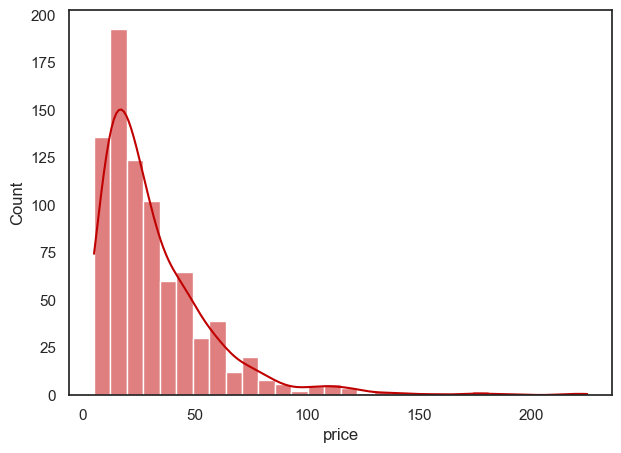

In [858]:
# Création de l'histogramme univarié
sns.set_theme(style="white")  # Définir le style du thème
histplot = sns.histplot(df_final['price'], bins=30, kde=True, color='#C00000')

In [859]:
# Sélectionnez la colonne pour laquelle vous voulez détecter les outliers
column = 'price'

# Calculer Q1 et Q3
Q1 = df_final[column].quantile(0.25)
Q3 = df_final[column].quantile(0.75)

# Calculer l'IQR
IQR = Q3 - Q1

# Définir les seuils pour les outliers
lower_bound = Q1 - 1.5 * IQR #borne inferieure
upper_bound = Q3 + 1.5 * IQR #borne superieure

# Détecter les outliers
outliers = df_final[(df_final[column] < lower_bound) | (df_final[column] > upper_bound)]

# Compter les outliers
nb_outliers = len(outliers)
 
# Proportion d'outliers
pourcentage_outliers = nb_outliers / len(df_final['price']) * 100



print(f"L'IQR de la colonne 'price'est:'{round(IQR, 2)}")
print('------------------------------------------------------')
print(f"La borne inférieure de la colonne'price'est:'{round(lower_bound, 2)}'")
print('------------------------------------------------------')
print(f"La borne supérieure de la colonne'price'est:'{round(upper_bound, 2)}'")

L'IQR de la colonne 'price'est:'27.4
------------------------------------------------------
La borne inférieure de la colonne'price'est:'-26.5'
------------------------------------------------------
La borne supérieure de la colonne'price'est:'83.1'


In [860]:
print(f"Nombre d\'outliers:{nb_outliers}")
print('------------------------------------------------------')
print(f"Proportion de l'ensemble du catalogue outliers:{round(pourcentage_outliers, 2)}%")
print('------------------------------------------------------')
print(f"Outliers détectés dans la colonne '{column}':")
print(outliers['price'])

Nombre d'outliers:36
------------------------------------------------------
Proportion de l'ensemble du catalogue outliers:4.36%
------------------------------------------------------
Outliers détectés dans la colonne 'price':
12      99.0
13     105.0
15      88.4
46     115.0
47     105.0
48     109.6
106     85.6
112     86.8
113    112.0
119     83.7
120    115.0
134    137.0
167    217.5
168    105.6
197    114.0
198     93.0
199    122.0
204    102.3
220    124.8
221    135.0
233    191.3
245    121.0
246    121.0
255    116.4
277    175.0
334    100.0
531    225.0
695     92.0
702    108.5
703    104.0
704    176.0
717    157.0
733     86.1
744    144.0
761     84.7
769     92.0
Name: price, dtype: float64


In [861]:
# Afficher les outliers
outliers.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore
12,6214,1,99.0,9.0,49.62,instock,11601,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-07-25 09:15:41,2019-07-25 07:15:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Champa...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-champa...,2020-07-04 11:35:02,2020-07-04 09:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.503514
13,5008,1,105.0,12.0,56.42,instock,11602,both,0.0,0.0,0.0,0.0,7.0,2.0,2018-07-17 10:52:41,2018-07-17 08:52:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-23 15:35:02,2020-06-23 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.728888
15,4132,1,88.4,7.0,44.30,instock,11668,both,0.0,0.0,0.0,0.0,5.0,2.0,2018-02-13 11:43:55,2018-02-13 10:43:55,Vin,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,publish,closed,closed,zind-humbrecht-pinot-gris-grand-cru-rangen-de-...,2020-02-20 09:55:02,2020-02-20 08:55:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.105354
46,6215,1,115.0,14.0,56.45,instock,12790,both,0.0,0.0,0.0,0.0,4.0,2.0,2019-07-25 09:30:16,2019-07-25 07:30:16,Vin,Domaine des Comtes Lafon Volnay 1er Cru Champa...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-champa...,2019-11-04 09:30:25,2019-11-04 08:30:25,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511
47,5007,1,105.0,15.0,55.88,instock,12791,both,0.0,0.0,0.0,0.0,3.0,2.0,2018-07-17 10:36:03,2018-07-17 08:36:03,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-07-02 09:30:03,2020-07-02 07:30:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.728888


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Analyse univarié du CA, des quantités vendues, des stocks et de la marge ainsi qu'une analyse multivarié  </h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.1 - Analyse des ventes en CA</h3>
</div>

In [862]:
df_final['ca_par_article'] = df_final['total_sales'] * df_final['price']
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article
0,5913,1,36.0,7.0,17.16,instock,10014,both,0.0,0.0,0.0,0.0,10.0,2.0,2019-04-04 15:45:23,2019-04-04 13:45:23,Gin,Darnley's London Dry Gin Original,publish,closed,closed,darnleys-london-dry-gin-original,2020-08-26 15:55:02,2020-08-26 13:55:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.137091,360.0
1,4617,1,67.5,6.0,35.57,instock,10459,both,0.0,0.0,0.0,0.0,4.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Vin,Alphonse Mellot Sancerre Rouge Génération XIX ...,publish,closed,closed,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,1.320303,270.0
2,4709,1,44.0,7.0,22.05,instock,10775,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-04-17 21:28:52,2018-04-17 19:28:52,Vin,Albert Mann Pinot Gris Vendanges Tardives Alte...,publish,closed,closed,albert-mann-pinot-gris-vendanges-tardives-alte...,2018-12-22 10:30:02,2018-12-22 09:30:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.437589,264.0
3,4656,1,43.0,13.0,22.88,instock,10814,both,0.0,0.0,0.0,0.0,7.0,2.0,2018-04-17 10:12:40,2018-04-17 08:12:40,Vin,Thierry Germain Saumur-Champigny Outre Terre 2013,publish,closed,closed,thierry-germain-saumur-champigny-outre-terre-2013,2020-08-05 14:35:02,2020-08-05 12:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.400027,301.0
4,4619,1,59.0,8.0,32.01,instock,11049,both,0.0,0.0,0.0,0.0,4.0,2.0,2018-04-13 16:07:49,2018-04-13 14:07:49,Vin,Alphonse Mellot Sancerre Rouge En Grands Champ...,publish,closed,closed,alphonse-mellot-sancerre-rouge-en-grands-champ...,2020-01-31 09:30:02,2020-01-31 08:30:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,1.001023,236.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN
823,7204,0,45.0,9.0,24.18,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN


In [863]:
# Calcul du chiffre d'affaires
round(df_final['ca_par_article'].sum(), 1)

143680.1

In [864]:
df_final.sort_values(by='ca_par_article', ascending=False, inplace=True)
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0
233,5892,1,191.3,98.0,116.06,instock,14983,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-03-28 10:21:36,2019-03-28 09:21:36,Champagne,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,publish,closed,closed,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,2020-04-01 09:30:09,2020-04-01 07:30:09,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,5.970513,1147.8
36,4353,1,79.5,127.0,45.91,instock,12587,both,0.0,0.0,0.0,0.0,14.0,2.0,2018-03-02 10:37:26,2018-03-02 09:37:26,Champagne,Champagne Egly-Ouriet Grand Cru Brut Rosé,publish,closed,closed,champagne-egly-ouriet-grand-cru-brut-rose,2020-08-22 11:45:02,2020-08-22 09:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,1.771050,1113.0
313,5826,1,41.2,34.0,21.71,instock,15325,both,0.0,0.0,0.0,0.0,20.0,2.0,2019-03-27 17:59:49,2019-03-27 16:59:49,Vin,Agnès Levet Côte Rôtie Améthyste 2017,publish,closed,closed,agnes-levet-amethyste-2017,2020-05-21 14:00:02,2020-05-21 12:00:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.332415,824.0
120,6212,1,115.0,16.0,59.42,instock,13996,both,0.0,0.0,0.0,0.0,7.0,2.0,2019-07-25 09:09:17,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-16 09:30:16,2020-06-16 07:30:16,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511,805.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN


In [865]:
df_final.reset_index()

top_20_articles_ca = df_final.head(20)
top_20_articles_ca

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0
233,5892,1,191.3,98.0,116.06,instock,14983,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-03-28 10:21:36,2019-03-28 09:21:36,Champagne,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,publish,closed,closed,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,2020-04-01 09:30:09,2020-04-01 07:30:09,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,5.970513,1147.8
36,4353,1,79.5,127.0,45.91,instock,12587,both,0.0,0.0,0.0,0.0,14.0,2.0,2018-03-02 10:37:26,2018-03-02 09:37:26,Champagne,Champagne Egly-Ouriet Grand Cru Brut Rosé,publish,closed,closed,champagne-egly-ouriet-grand-cru-brut-rose,2020-08-22 11:45:02,2020-08-22 09:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,1.771050,1113.0
313,5826,1,41.2,34.0,21.71,instock,15325,both,0.0,0.0,0.0,0.0,20.0,2.0,2019-03-27 17:59:49,2019-03-27 16:59:49,Vin,Agnès Levet Côte Rôtie Améthyste 2017,publish,closed,closed,agnes-levet-amethyste-2017,2020-05-21 14:00:02,2020-05-21 12:00:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.332415,824.0
120,6212,1,115.0,16.0,59.42,instock,13996,both,0.0,0.0,0.0,0.0,7.0,2.0,2019-07-25 09:09:17,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-16 09:30:16,2020-06-16 07:30:16,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511,805.0
112,5026,1,86.8,101.0,50.13,instock,13913,both,0.0,0.0,0.0,0.0,9.0,2.0,2018-07-18 10:46:30,2018-07-18 08:46:30,Champagne,Champagne Agrapart &amp; Fils Minéral Extra Br...,publish,closed,closed,champagne-agrapart-fils-mineral-extra-brut-bla...,2020-05-11 14:35:02,2020-05-11 12:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.045255,781.2
13,5008,1,105.0,12.0,56.42,instock,11602,both,0.0,0.0,0.0,0.0,7.0,2.0,2018-07-17 10:52:41,2018-07-17 08:52:41,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-23 15:35:02,2020-06-23 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.728888,735.0
277,5767,1,175.0,12.0,90.42,instock,15185,both,0.0,0.0,0.0,0.0,4.0,2.0,2019-03-13 14:43:22,2019-03-13 13:43:22,Vin,Camille Giroud Clos de Vougeot 2016,publish,closed,closed,camille-giroud-clos-de-vougeot-2016,2020-06-11 15:25:04,2020-06-11 13:25:04,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,5.358248,700.0
221,6126,1,135.0,138.0,80.33,instock,14923,both,0.0,0.0,0.0,0.0,5.0,2.0,2019-06-28 17:22:27,2019-06-28 15:22:27,Champagne,Champagne Gosset Célébris Vintage 2007,publish,closed,closed,champagne-gosset-celebris-vintage-2007,2020-08-27 11:45:02,2020-08-27 09:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.855756,675.0
113,5025,1,112.0,136.0,68.60,instock,13914,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-07-18 10:39:43,2018-07-18 08:39:43,Champagne,Champagne Agrapart &amp; Fils L'Avizoise Extra...,publish,closed,closed,champagne-agrapart-fils-lavizoise-grand-cru-20...,2020-07-09 17:05:02,2020-07-09 15:05:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,2.991824,672.0


In [866]:
# Graphique plotly des 20 premiers articles
graph2 = px.bar(top_20_articles_ca, x='sku', y='ca_par_article', title = 'Top 20 des articles les plus vendus (en €)', width = 600,  height = 400,
labels = { 'ca_par_article' : 'Chiffre d\'Affaires','sku' : 'Articles' })
graph2.update_traces(marker_color='#C00000')
graph2.show()

In [867]:
# Créer une colonne calculant la part du CA de la ligne dans le dataset
df_final['ca_%'] = df_final['ca_par_article'] / df_final['ca_par_article'].sum() * 100
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577
233,5892,1,191.3,98.0,116.06,instock,14983,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-03-28 10:21:36,2019-03-28 09:21:36,Champagne,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,publish,closed,closed,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,2020-04-01 09:30:09,2020-04-01 07:30:09,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,5.970513,1147.8,0.798858
36,4353,1,79.5,127.0,45.91,instock,12587,both,0.0,0.0,0.0,0.0,14.0,2.0,2018-03-02 10:37:26,2018-03-02 09:37:26,Champagne,Champagne Egly-Ouriet Grand Cru Brut Rosé,publish,closed,closed,champagne-egly-ouriet-grand-cru-brut-rose,2020-08-22 11:45:02,2020-08-22 09:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,1.771050,1113.0,0.774638
313,5826,1,41.2,34.0,21.71,instock,15325,both,0.0,0.0,0.0,0.0,20.0,2.0,2019-03-27 17:59:49,2019-03-27 16:59:49,Vin,Agnès Levet Côte Rôtie Améthyste 2017,publish,closed,closed,agnes-levet-amethyste-2017,2020-05-21 14:00:02,2020-05-21 12:00:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.332415,824.0,0.573496
120,6212,1,115.0,16.0,59.42,instock,13996,both,0.0,0.0,0.0,0.0,7.0,2.0,2019-07-25 09:09:17,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-16 09:30:16,2020-06-16 07:30:16,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511,805.0,0.560272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN,NaN


In [868]:
# Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_final['ca_%_cumul'] = df_final['ca_%'].cumsum()
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577,1.722577
233,5892,1,191.3,98.0,116.06,instock,14983,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-03-28 10:21:36,2019-03-28 09:21:36,Champagne,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,publish,closed,closed,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,2020-04-01 09:30:09,2020-04-01 07:30:09,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,5.970513,1147.8,0.798858,2.521435
36,4353,1,79.5,127.0,45.91,instock,12587,both,0.0,0.0,0.0,0.0,14.0,2.0,2018-03-02 10:37:26,2018-03-02 09:37:26,Champagne,Champagne Egly-Ouriet Grand Cru Brut Rosé,publish,closed,closed,champagne-egly-ouriet-grand-cru-brut-rose,2020-08-22 11:45:02,2020-08-22 09:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,1.771050,1113.0,0.774638,3.296072
313,5826,1,41.2,34.0,21.71,instock,15325,both,0.0,0.0,0.0,0.0,20.0,2.0,2019-03-27 17:59:49,2019-03-27 16:59:49,Vin,Agnès Levet Côte Rôtie Améthyste 2017,publish,closed,closed,agnes-levet-amethyste-2017,2020-05-21 14:00:02,2020-05-21 12:00:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.332415,824.0,0.573496,3.869569
120,6212,1,115.0,16.0,59.42,instock,13996,both,0.0,0.0,0.0,0.0,7.0,2.0,2019-07-25 09:09:17,2019-07-25 07:09:17,Vin,Domaine des Comtes Lafon Volnay 1er Cru Santen...,publish,closed,closed,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2020-06-16 09:30:16,2020-06-16 07:30:16,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,3.104511,805.0,0.560272,4.429841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN,NaN,NaN


In [869]:
# Grâce au deux colonnes créées précedemment, calcul du nombre d'articles représentant 80% du CA
articles_80_perc_ca = df_final.loc[df_final['ca_%_cumul'] < 81]
articles_80_perc_ca = len(articles_80_perc_ca['ca_%_cumul'])

print(f"Nombre d'articles qui représentent 80% du CA: {articles_80_perc_ca}")

Nombre d'articles qui représentent 80% du CA: 444


In [870]:
# Calcul du nombre total d'articles
total_articles = df_final['product_id'].shape[0]
print(f"Nombre total d'articles: {total_articles}")

# Calcul de la proportion que représente ce groupe d'articles dans le catalogue entier
proportion_groupe_articles = round(articles_80_perc_ca / total_articles * 100, 1)
print(f"Proportion du groupes d'articles dans le catalogue entier: {proportion_groupe_articles}%")

Nombre total d'articles: 825
Proportion du groupes d'articles dans le catalogue entier: 53.8%


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.2 - Analyse des ventes en Quantités</h3>
</div>

In [871]:
# Effectuer le tri dans l'ordre décroissant de quantités vendues du dataset df_merge
df_final.sort_values(by='total_sales', ascending=False, inplace=True)
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul
600,4867,1,9.9,121.0,4.86,instock,16148,both,0.0,0.0,0.0,0.0,36.0,2.0,2018-05-03 13:20:05,2018-05-03 11:20:05,Vin,Château De La Selve IGP Coteaux de l'Ardèche M...,publish,closed,closed,chateau-de-la-selve-igp-coteaux-de-lardeche-ma...,2020-08-27 09:30:15,2020-08-27 07:30:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,356.4,0.248051,22.799330
341,4203,1,9.9,74.0,5.01,instock,15415,both,0.0,0.0,0.0,0.0,27.0,2.0,2018-02-15 14:33:42,2018-02-15 13:33:42,Vin,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,publish,closed,closed,mas-laval-igp-pays-herault-pampres-blanc-2018,2020-07-11 16:45:03,2020-07-11 14:45:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,267.3,0.186038,40.239045
214,4275,1,14.9,62.0,7.78,instock,14864,both,0.0,0.0,0.0,0.0,24.0,2.0,2018-02-27 13:33:54,2018-02-27 12:33:54,Vin,I Fabbri Chianti Classico Lamole 2017,publish,closed,closed,i-fabbri-chianti-classico-lamole-2017,2020-08-22 14:35:02,2020-08-22 12:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.655473,357.6,0.248886,21.557543
226,4726,1,12.7,0.0,6.82,outofstock,14950,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-18 11:53:51,2018-04-18 09:53:51,Vin,François Baur Pinot Noir Schlittweg 2017,publish,closed,closed,francois-baur-pinot-noir-schlittweg-2017,2020-05-06 11:35:01,2020-05-06 09:35:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.738110,279.4,0.194460,36.807324
674,4647,1,28.5,45.0,14.14,instock,16525,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-17 09:28:58,2018-04-17 07:28:58,Vin,Bernard Baudry Chinon Rouge La Croix Boissée 2017,publish,closed,closed,bernard-baudry-chinon-rouge-croix-boissee-2017,2020-07-31 09:31:39,2020-07-31 07:31:39,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.144626,627.0,0.436386,8.224243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN,NaN,NaN


In [872]:
df_final.reset_index()
top_20_ventes_qte = df_final.head(20)

In [873]:
# Graphique en barre des 20 premiers articles vendus en quantité avec plotly express
graph3 = px.bar(top_20_ventes_qte, x='sku', y='total_sales', title = 'Top 20 des articles les plus vendus en quantité', width = 600,  height = 400,
labels = { 'total_sales' : 'Quantités vendues' })
graph3.update_traces(marker_color='#C00000', orientation='v')
graph3.show()

In [874]:
# Créer une colonne calculant la part en quantité de la ligne dans le dataset
df_final['total_sales_%'] = df_final['total_sales'] / df_final['total_sales'].sum() * 100 
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%
600,4867,1,9.9,121.0,4.86,instock,16148,both,0.0,0.0,0.0,0.0,36.0,2.0,2018-05-03 13:20:05,2018-05-03 11:20:05,Vin,Château De La Selve IGP Coteaux de l'Ardèche M...,publish,closed,closed,chateau-de-la-selve-igp-coteaux-de-lardeche-ma...,2020-08-27 09:30:15,2020-08-27 07:30:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,356.4,0.248051,22.799330,0.625978
341,4203,1,9.9,74.0,5.01,instock,15415,both,0.0,0.0,0.0,0.0,27.0,2.0,2018-02-15 14:33:42,2018-02-15 13:33:42,Vin,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,publish,closed,closed,mas-laval-igp-pays-herault-pampres-blanc-2018,2020-07-11 16:45:03,2020-07-11 14:45:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,267.3,0.186038,40.239045,0.469484
214,4275,1,14.9,62.0,7.78,instock,14864,both,0.0,0.0,0.0,0.0,24.0,2.0,2018-02-27 13:33:54,2018-02-27 12:33:54,Vin,I Fabbri Chianti Classico Lamole 2017,publish,closed,closed,i-fabbri-chianti-classico-lamole-2017,2020-08-22 14:35:02,2020-08-22 12:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.655473,357.6,0.248886,21.557543,0.417319
226,4726,1,12.7,0.0,6.82,outofstock,14950,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-18 11:53:51,2018-04-18 09:53:51,Vin,François Baur Pinot Noir Schlittweg 2017,publish,closed,closed,francois-baur-pinot-noir-schlittweg-2017,2020-05-06 11:35:01,2020-05-06 09:35:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.738110,279.4,0.194460,36.807324,0.382542
674,4647,1,28.5,45.0,14.14,instock,16525,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-17 09:28:58,2018-04-17 07:28:58,Vin,Bernard Baudry Chinon Rouge La Croix Boissée 2017,publish,closed,closed,bernard-baudry-chinon-rouge-croix-boissee-2017,2020-07-31 09:31:39,2020-07-31 07:31:39,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.144626,627.0,0.436386,8.224243,0.382542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN,NaN,NaN,NaN


In [875]:
# Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_final['total_sales_%_cumul'] = df_final['total_sales_%'].cumsum()
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul
600,4867,1,9.9,121.0,4.86,instock,16148,both,0.0,0.0,0.0,0.0,36.0,2.0,2018-05-03 13:20:05,2018-05-03 11:20:05,Vin,Château De La Selve IGP Coteaux de l'Ardèche M...,publish,closed,closed,chateau-de-la-selve-igp-coteaux-de-lardeche-ma...,2020-08-27 09:30:15,2020-08-27 07:30:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,356.4,0.248051,22.799330,0.625978,0.625978
341,4203,1,9.9,74.0,5.01,instock,15415,both,0.0,0.0,0.0,0.0,27.0,2.0,2018-02-15 14:33:42,2018-02-15 13:33:42,Vin,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,publish,closed,closed,mas-laval-igp-pays-herault-pampres-blanc-2018,2020-07-11 16:45:03,2020-07-11 14:45:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,267.3,0.186038,40.239045,0.469484,1.095462
214,4275,1,14.9,62.0,7.78,instock,14864,both,0.0,0.0,0.0,0.0,24.0,2.0,2018-02-27 13:33:54,2018-02-27 12:33:54,Vin,I Fabbri Chianti Classico Lamole 2017,publish,closed,closed,i-fabbri-chianti-classico-lamole-2017,2020-08-22 14:35:02,2020-08-22 12:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.655473,357.6,0.248886,21.557543,0.417319,1.512780
226,4726,1,12.7,0.0,6.82,outofstock,14950,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-18 11:53:51,2018-04-18 09:53:51,Vin,François Baur Pinot Noir Schlittweg 2017,publish,closed,closed,francois-baur-pinot-noir-schlittweg-2017,2020-05-06 11:35:01,2020-05-06 09:35:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.738110,279.4,0.194460,36.807324,0.382542,1.895323
674,4647,1,28.5,45.0,14.14,instock,16525,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-17 09:28:58,2018-04-17 07:28:58,Vin,Bernard Baudry Chinon Rouge La Croix Boissée 2017,publish,closed,closed,bernard-baudry-chinon-rouge-croix-boissee-2017,2020-07-31 09:31:39,2020-07-31 07:31:39,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.144626,627.0,0.436386,8.224243,0.382542,2.277865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN,NaN,NaN,NaN,NaN


In [876]:
# Calculer le nombre d'articles représentant 80% des ventes en quantité
df_articles_80_perc_qte = df_final.loc[df_final['total_sales_%_cumul'] < 81]
nb_articles_80_perc_qte = len(df_articles_80_perc_qte['total_sales_%_cumul'])
print(f"Nombre d'articles qui représentent 80% des ventes en quantité: {nb_articles_80_perc_qte}")

Nombre d'articles qui représentent 80% des ventes en quantité: 441


In [877]:
print(f"Nombre total d'articles: {total_articles}")
print(f"Nombre d'articles qui représentent 80% des ventes en quantité: {nb_articles_80_perc_qte}")

# Calcul de la proportion que représente ce groupe d'articles dans le catalogue entier
proportion_groupe_articles = round(nb_articles_80_perc_qte / total_articles * 100, 1)

print(f"Proportion du groupes d'articles dans le catalogue: {proportion_groupe_articles}%")

Nombre total d'articles: 825
Nombre d'articles qui représentent 80% des ventes en quantité: 441
Proportion du groupes d'articles dans le catalogue: 53.5%


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.3 - Analyse des stocks</h3>
</div>

### Calculer et interpréter les ratios de stock
#### Les formules de calcul
* **Taux de couverture** = qté vendue/qté en stock
* **Taux de rotation de stock** = qté achetée/(stock initial + stock final)/2) 

#### Interpréter ces ratios
##### Le taux de couverture
* La **couverture des stocks** est une valeur numérique qui indique le nombre de jours, semaines, mois pendant lesquels une entreprise peut servir ses commandes avec les stocks disponibles. Logiquement, **l’objectif est de viser une grande valeur** pour maximiser la disponibilité des stocks sans besoin de réapprovisionnement.

* En revanche, **une faible couverture des stocks** entraîne un risque de rupture de stock. Autrement dit, la probabilité de ne pas pouvoir honorer les commandes en raison de l’indisponibilité des stocks. 

##### Le taux de rotation de stock
* Il est d'usage de considérer ce coefficent entre 2 et 4 chez un e-commerçant même si celui-ci peut varier.
* Un ratio faible peut indiquer des ventes faibles ou un niveau excessif de stocks (excédents de stocks).
* C'est la raison pour laquelle les entreprises visent un ratio de rotation élevé parce qu’il indique de solides ventes et des stocks qui se renouvellent rapidement.

En fonction des données disponibles et de la périodicité, içi le mois d'octobre uniquement, le calcul du taux de couverture peut-être calculé.

In [878]:
# Création de la colonne couverture de stock
df_final['couverture_de_stock'] = df_final['stock_quantity'] / df_final['total_sales']
df_final

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock
600,4867,1,9.9,121.0,4.86,instock,16148,both,0.0,0.0,0.0,0.0,36.0,2.0,2018-05-03 13:20:05,2018-05-03 11:20:05,Vin,Château De La Selve IGP Coteaux de l'Ardèche M...,publish,closed,closed,chateau-de-la-selve-igp-coteaux-de-lardeche-ma...,2020-08-27 09:30:15,2020-08-27 07:30:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,356.4,0.248051,22.799330,0.625978,0.625978,3.361111
341,4203,1,9.9,74.0,5.01,instock,15415,both,0.0,0.0,0.0,0.0,27.0,2.0,2018-02-15 14:33:42,2018-02-15 13:33:42,Vin,Mas Laval IGP Pays d'Hérault Les Pampres Blanc...,publish,closed,closed,mas-laval-igp-pays-herault-pampres-blanc-2018,2020-07-11 16:45:03,2020-07-11 14:45:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.843285,267.3,0.186038,40.239045,0.469484,1.095462,2.740741
214,4275,1,14.9,62.0,7.78,instock,14864,both,0.0,0.0,0.0,0.0,24.0,2.0,2018-02-27 13:33:54,2018-02-27 12:33:54,Vin,I Fabbri Chianti Classico Lamole 2017,publish,closed,closed,i-fabbri-chianti-classico-lamole-2017,2020-08-22 14:35:02,2020-08-22 12:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.655473,357.6,0.248886,21.557543,0.417319,1.512780,2.583333
226,4726,1,12.7,0.0,6.82,outofstock,14950,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-18 11:53:51,2018-04-18 09:53:51,Vin,François Baur Pinot Noir Schlittweg 2017,publish,closed,closed,francois-baur-pinot-noir-schlittweg-2017,2020-05-06 11:35:01,2020-05-06 09:35:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.738110,279.4,0.194460,36.807324,0.382542,1.895323,0.000000
674,4647,1,28.5,45.0,14.14,instock,16525,both,0.0,0.0,0.0,0.0,22.0,2.0,2018-04-17 09:28:58,2018-04-17 07:28:58,Vin,Bernard Baudry Chinon Rouge La Croix Boissée 2017,publish,closed,closed,bernard-baudry-chinon-rouge-croix-boissee-2017,2020-07-31 09:31:39,2020-07-31 07:31:39,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.144626,627.0,0.436386,8.224243,0.382542,2.277865,2.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,7196,0,31.0,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN,NaN
820,7200,0,31.0,6.0,15.54,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN,NaN
821,7201,0,31.0,18.0,16.02,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN,NaN
822,7203,0,45.0,30.0,23.48,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0.475151,NaN,NaN,NaN,NaN,NaN,NaN


Remplacement des "inf" par 0

In [879]:
df_final.loc[df_final['couverture_de_stock'] == 'inf', 'couverture_de_stock'] = 0

In [880]:
df_final.loc[df_final['couverture_de_stock'] =='inf']

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock


Effectuer le tri dans l'ordre décroissant du nombre de mois de stock dans le dataset df_merge

In [881]:
df_final.sort_values(by='couverture_de_stock', ascending=True, inplace=True)

In [882]:
df_final.loc[:, ['stock_quantity', 'total_sales', 'stock_status_2', 'couverture_de_stock']].head(20)

,stock_quantity,total_sales,stock_status_2,couverture_de_stock
257,0.0,6.0,outofstock,0.0
590,0.0,9.0,outofstock,0.0
531,0.0,11.0,outofstock,0.0
657,0.0,14.0,outofstock,0.0
609,0.0,6.0,outofstock,0.0
545,0.0,7.0,outofstock,0.0
435,0.0,4.0,outofstock,0.0
605,0.0,8.0,outofstock,0.0
52,0.0,8.0,outofstock,0.0
242,0.0,5.0,outofstock,0.0


In [883]:
graph4 = px.bar(df_final.head(20), x='sku', y='couverture_de_stock', title = 'Top 20 des articles qui risquent la rupture de stock', width = 600,  height = 400)
#labels = { 'total_sales' : 'Quantités vendues' })
graph4.update_traces(marker_color='#C00000', orientation='v')
graph4.show()

Les 20 premiers articles sont en rupture de stock, leur coefficent de couverture est égal à 0 et répertotiés outofstock.

In [884]:
df_final.head(20).to_excel('couverture_de_stock.xlsx')

Valorisation des stocks en euros
* Les stocks sont valorisés selon leurs coûts d'achat

In [885]:
df_final['valorisation_des_stocks_(€)'] = df_final['stock_quantity'] * df_final['purchase_price']
df_final.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€)
257,6050,1,38.5,0.0,20.09,outofstock,15134,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-05-07 17:25:10,2019-05-07 15:25:10,Vin,Christophe Pichon Condrieu 2017,publish,closed,closed,christophe-pichon-saint-condrieu-2017,2019-09-23 09:31:17,2019-09-23 07:31:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.230997,231.0,0.160774,48.754942,0.104330,87.515215,0.0,0.0
590,5487,1,43.5,0.0,23.37,outofstock,16129,both,0.0,0.0,0.0,0.0,9.0,2.0,2018-10-09 15:27:50,2018-10-09 13:27:50,Vin,Decelle-Villa Nuits-Saint-Georges Rouge 2016,publish,closed,closed,decelle-villa-nuits-st-georges-rouge-2016,2020-06-13 15:55:07,2020-06-13 13:55:07,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.418808,391.5,0.272480,18.729038,0.156495,57.398713,0.0,0.0
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577,1.722577,0.191271,37.784733,0.0,0.0
657,5930,1,14.1,0.0,6.92,outofstock,16323,both,0.0,0.0,0.0,0.0,14.0,2.0,2019-04-06 10:36:51,2019-04-06 08:36:51,Vin,Borie La Vitarèle Languedoc Blanc Le Grand May...,publish,closed,closed,borie-la-vitarele-languedoc-blanc-grand-mayol-...,2020-08-27 09:25:48,2020-08-27 07:25:48,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.685523,197.4,0.137389,60.856061,0.243436,14.206225,0.0,0.0
609,4179,1,24.0,0.0,13.02,outofstock,16166,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-02-14 17:48:16,2018-02-14 16:48:16,Vin,Domaine de l'Hortus Pic Saint-Loup La Grande C...,publish,closed,closed,hortus-pic-saint-loup-grande-cuvee-2018,2020-08-27 10:08:37,2020-08-27 08:08:37,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.313656,144.0,0.100223,81.702964,0.104330,88.975830,0.0,0.0


In [886]:
valorisation_stock_euros = round(df_final['valorisation_des_stocks_(€)'].sum(), 1)
print(f'Le stock est valorisé: {valorisation_stock_euros}€')

Le stock est valorisé: 298627.7€


Valorisation du nombre de produit en stock

In [887]:
quantite_stock = df_final['stock_quantity'].sum()
print(f'La quantité totale de produits s\'élève à: {quantite_stock}')

La quantité totale de produits s'élève à: 17822.0


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.4 - Analyse du taux de marge</h3>
</div>

Création de la colonne prix HT

In [888]:
df_final['prix_ht'] = df_final['price'] / 1.2
df_final.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€),prix_ht
257,6050,1,38.5,0.0,20.09,outofstock,15134,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-05-07 17:25:10,2019-05-07 15:25:10,Vin,Christophe Pichon Condrieu 2017,publish,closed,closed,christophe-pichon-saint-condrieu-2017,2019-09-23 09:31:17,2019-09-23 07:31:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.230997,231.0,0.160774,48.754942,0.104330,87.515215,0.0,0.0,32.083333
590,5487,1,43.5,0.0,23.37,outofstock,16129,both,0.0,0.0,0.0,0.0,9.0,2.0,2018-10-09 15:27:50,2018-10-09 13:27:50,Vin,Decelle-Villa Nuits-Saint-Georges Rouge 2016,publish,closed,closed,decelle-villa-nuits-st-georges-rouge-2016,2020-06-13 15:55:07,2020-06-13 13:55:07,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.418808,391.5,0.272480,18.729038,0.156495,57.398713,0.0,0.0,36.250000
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577,1.722577,0.191271,37.784733,0.0,0.0,187.500000
657,5930,1,14.1,0.0,6.92,outofstock,16323,both,0.0,0.0,0.0,0.0,14.0,2.0,2019-04-06 10:36:51,2019-04-06 08:36:51,Vin,Borie La Vitarèle Languedoc Blanc Le Grand May...,publish,closed,closed,borie-la-vitarele-languedoc-blanc-grand-mayol-...,2020-08-27 09:25:48,2020-08-27 07:25:48,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.685523,197.4,0.137389,60.856061,0.243436,14.206225,0.0,0.0,11.750000
609,4179,1,24.0,0.0,13.02,outofstock,16166,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-02-14 17:48:16,2018-02-14 16:48:16,Vin,Domaine de l'Hortus Pic Saint-Loup La Grande C...,publish,closed,closed,hortus-pic-saint-loup-grande-cuvee-2018,2020-08-27 10:08:37,2020-08-27 08:08:37,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.313656,144.0,0.100223,81.702964,0.104330,88.975830,0.0,0.0,20.000000


### Calculer et interpréter les taux de marge et marque

#### Calculer les indicateurs de marge
* **Marge commerciale** = prix ht - coût d'achat
* **Taux de marge** = [ marge commerciale / coût d’achat ] x 100
* **Taux de marque** = [ marge commerciale / prix de vente HT ] x 100

#### Interpréter les indicateurs de marge
##### Le taux de marque
* **Le taux de marque** est exprimé en pourcentage et permet de déterminer la marge bénéficiaire réalisée sur la vente d'un produit ou d'un service. Un taux de marque élevé indique une forte rentabilité de la vente d'un produit ou d'un service.
* Celui-ci ne peut être supérieur à 100 % dans la mesure où la marge commerciale ne peut être supérieure au prix de vente.

##### Le taux de marge

* **Le taux de marge** permet d’identifier un profit et de suivre plus globalement l'évolution du chiffre d'affaires de l'entreprise. Connaître cette information permet de mesurer son pouvoir de négociation auprès de ses fournisseurs.

#### Différence entre taux de marque et taux de marge
* Souvent confondus, la principale différence entre ces deux indicateurs est que l’un est calculé à partir du prix de vente d’un produit (Tx marque) et correspond au pourcentage de marge réalisée par l’entreprise, l’autre à partir du coût d’achat d’un produit (Tx marge) correspondant à ce que l’entreprise gagne entre le PAHT et le PVHT

In [889]:
# Création de la colonne marge commerciale
df_final['marge_commerciale'] = df_final['prix_ht'] - df_final['purchase_price']

# Création de la colonne taux de marque
df_final['taux_de_marque'] = df_final['marge_commerciale'] / df_final['prix_ht'] * 100
df_final.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€),prix_ht,marge_commerciale,taux_de_marque
257,6050,1,38.5,0.0,20.09,outofstock,15134,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-05-07 17:25:10,2019-05-07 15:25:10,Vin,Christophe Pichon Condrieu 2017,publish,closed,closed,christophe-pichon-saint-condrieu-2017,2019-09-23 09:31:17,2019-09-23 07:31:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.230997,231.0,0.160774,48.754942,0.104330,87.515215,0.0,0.0,32.083333,11.993333,37.381818
590,5487,1,43.5,0.0,23.37,outofstock,16129,both,0.0,0.0,0.0,0.0,9.0,2.0,2018-10-09 15:27:50,2018-10-09 13:27:50,Vin,Decelle-Villa Nuits-Saint-Georges Rouge 2016,publish,closed,closed,decelle-villa-nuits-st-georges-rouge-2016,2020-06-13 15:55:07,2020-06-13 13:55:07,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.418808,391.5,0.272480,18.729038,0.156495,57.398713,0.0,0.0,36.250000,12.880000,35.531034
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577,1.722577,0.191271,37.784733,0.0,0.0,187.500000,49.690000,26.501333
657,5930,1,14.1,0.0,6.92,outofstock,16323,both,0.0,0.0,0.0,0.0,14.0,2.0,2019-04-06 10:36:51,2019-04-06 08:36:51,Vin,Borie La Vitarèle Languedoc Blanc Le Grand May...,publish,closed,closed,borie-la-vitarele-languedoc-blanc-grand-mayol-...,2020-08-27 09:25:48,2020-08-27 07:25:48,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.685523,197.4,0.137389,60.856061,0.243436,14.206225,0.0,0.0,11.750000,4.830000,41.106383
609,4179,1,24.0,0.0,13.02,outofstock,16166,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-02-14 17:48:16,2018-02-14 16:48:16,Vin,Domaine de l'Hortus Pic Saint-Loup La Grande C...,publish,closed,closed,hortus-pic-saint-loup-grande-cuvee-2018,2020-08-27 10:08:37,2020-08-27 08:08:37,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.313656,144.0,0.100223,81.702964,0.104330,88.975830,0.0,0.0,20.000000,6.980000,34.900000


Afficher le prix minimum de la colonne "taux_marque"

In [890]:
df_final['taux_de_marque'].min()

-634.98814229249

Afficher le prix maximum de la colonne "taux_marque"

In [891]:
df_final['taux_de_marque'].max()

47.7568

In [892]:
#affichage de la ligne avec un taux de marge inférieur à 0
df_final.loc[df_final['taux_de_marque'] < 0, :]

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€),prix_ht,marge_commerciale,taux_de_marque
38,4355,1,12.65,97.0,77.48,instock,12589,both,0.0,0.0,0.0,0.0,0.0,2.0,2018-03-02 10:46:10,2018-03-02 09:46:10,Champagne,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,publish,closed,closed,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,2020-08-13 10:15:02,2020-08-13 08:15:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.739988,0.0,0.0,100.0,0.0,100.0,inf,7515.56,10.541667,-66.938333,-634.988142
267,4864,0,8.30,0.0,9.99,outofstock,15154,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.903384,NaN,NaN,NaN,NaN,NaN,NaN,0.00,6.916667,-3.073333,-44.433735
769,6324,0,92.00,18.0,99.00,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,2.240578,NaN,NaN,NaN,NaN,NaN,NaN,1782.00,76.666667,-22.333333,-29.130435
819,7196,0,31.00,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN,NaN,1716.00,25.833333,-5.366667,-20.774194


* 4 produits ont un prix de vente inférieur à leur prix d'achat : vente à perte
* 1 produit vendu sur les 4 (product_id 4355)
* Erreurs de saisi des prix de vente : à corriger

création d'un dataframe avec les taux positifs

In [893]:
taux_de_marque_positif = df_final.loc[df_final['taux_de_marque'] > 0, :]
taux_de_marque_positif.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€),prix_ht,marge_commerciale,taux_de_marque
257,6050,1,38.5,0.0,20.09,outofstock,15134,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-05-07 17:25:10,2019-05-07 15:25:10,Vin,Christophe Pichon Condrieu 2017,publish,closed,closed,christophe-pichon-saint-condrieu-2017,2019-09-23 09:31:17,2019-09-23 07:31:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.230997,231.0,0.160774,48.754942,0.104330,87.515215,0.0,0.0,32.083333,11.993333,37.381818
590,5487,1,43.5,0.0,23.37,outofstock,16129,both,0.0,0.0,0.0,0.0,9.0,2.0,2018-10-09 15:27:50,2018-10-09 13:27:50,Vin,Decelle-Villa Nuits-Saint-Georges Rouge 2016,publish,closed,closed,decelle-villa-nuits-st-georges-rouge-2016,2020-06-13 15:55:07,2020-06-13 13:55:07,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.418808,391.5,0.272480,18.729038,0.156495,57.398713,0.0,0.0,36.250000,12.880000,35.531034
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577,1.722577,0.191271,37.784733,0.0,0.0,187.500000,49.690000,26.501333
657,5930,1,14.1,0.0,6.92,outofstock,16323,both,0.0,0.0,0.0,0.0,14.0,2.0,2019-04-06 10:36:51,2019-04-06 08:36:51,Vin,Borie La Vitarèle Languedoc Blanc Le Grand May...,publish,closed,closed,borie-la-vitarele-languedoc-blanc-grand-mayol-...,2020-08-27 09:25:48,2020-08-27 07:25:48,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.685523,197.4,0.137389,60.856061,0.243436,14.206225,0.0,0.0,11.750000,4.830000,41.106383
609,4179,1,24.0,0.0,13.02,outofstock,16166,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-02-14 17:48:16,2018-02-14 16:48:16,Vin,Domaine de l'Hortus Pic Saint-Loup La Grande C...,publish,closed,closed,hortus-pic-saint-loup-grande-cuvee-2018,2020-08-27 10:08:37,2020-08-27 08:08:37,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.313656,144.0,0.100223,81.702964,0.104330,88.975830,0.0,0.0,20.000000,6.980000,34.900000


Afficher le prix minimum de la colonne "taux_marque"

In [894]:
# Taux de marque minimum
round(taux_de_marque_positif['taux_de_marque'], 1).min()

22.8

Afficher le prix maximum de la colonne "taux_marque"

In [895]:
round(taux_de_marque_positif['taux_de_marque'], 1).max()

47.8

création d'un dataframe avec le taux de marque moyen par type de produit classé par ordre décroissant du taux de marque

In [896]:
taux_de_marque_moyen_par_produit = df_final.pivot_table(index=['product_type'], values='taux_de_marque', aggfunc='mean')
taux_de_marque_moyen_par_produit = taux_de_marque_moyen_par_produit.reset_index()
taux_de_marque_moyen_par_produit.sort_values(by='taux_de_marque', ascending=False, inplace=True)
taux_de_marque_moyen_par_produit.head()

,product_type,taux_de_marque
1,Cognac,45.067614
5,Whisky,44.918865
2,Gin,42.800000
4,Vin,38.012262
3,Huile d'olive,24.998198


Afficher le graphique du taux de marque moyen par type de produit


In [897]:
# Définir une palette de couleurs personnalisée
custom_palette = ['#C00000', '#C71200', '#F05051', '#F76966', '#EF9895', '#EEC8CC']
    
# Appliquer la palette de couleurs personnalisée
#sns.set_palette(custom_palette)

# Définir le style du graphique
custom_style = {
        "axes.facecolor": "white",
        "axes.edgecolor": "#232628",
        "axes.grid": False,
        "grid.color": "white",
        "grid.linestyle": "-",
        "xtick.color": "#232628",
        "ytick.color": "#232628",
        "axes.labelcolor": "#232628",
        "axes.titlesize": 11,
        "axes.titleweight": "normal",
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "font.family": "sans-serif",
        "font.sans-serif": ["Lato"],
}

# Définir le contexte du graphique
custom_context = {
        "figure.figsize": (7, 5),
        "figure.dpi": 100,
        "lines.linewidth": 2,
        "lines.markersize": 6,
}

C:\Users\jerem\AppData\Local\Temp\ipykernel_8532\3045437182.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




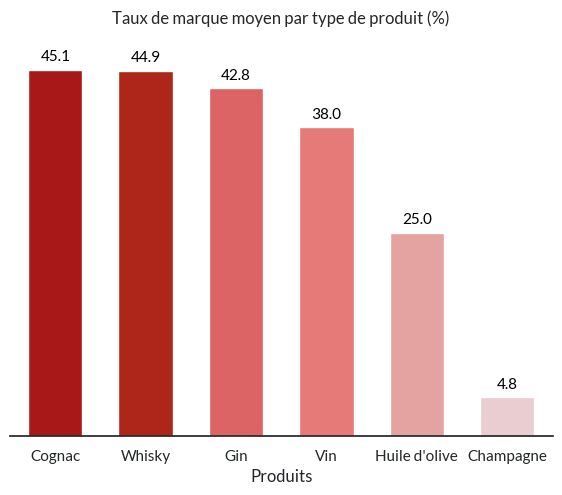

In [898]:
# Appliquer le style et le contexte personnalisés
sns.set_theme(style=custom_style, rc=custom_context)

# Création d'un histogramme avec Seaborn
graph5 = sns.barplot(x='product_type', y='taux_de_marque', data=taux_de_marque_moyen_par_produit, palette=custom_palette, width=0.6)

# Affichage du graphique
plt.title('Taux de marque moyen par type de produit (%)', pad=20)
plt.xlabel('Produits')
plt.ylabel('Taux de marquee (%)')
graph5.get_yaxis().set_visible(False)

# Suppression des bordures supérieures et droites
sns.despine(top=True, right=True, left=True)

# Ajouter des étiquettes sur chaque barre
for i, bar in enumerate(graph5.patches):
    graph5.annotate(format(bar.get_height(), '.1f'),
                (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11, color='black')
plt.show()

In [899]:
taux_de_marque_moyen_par_produit.to_excel('taux_de_marque.xlsx')

Calcul du taux de marge commerciale

In [900]:
# Création de la colonne taux de marge
df_final['taux_de_marge'] = df_final['marge_commerciale'] / df_final['purchase_price'] * 100
df_final.head()

,product_id,onsale_web,price,stock_quantity,purchase_price,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€),prix_ht,marge_commerciale,taux_de_marque,taux_de_marge
257,6050,1,38.5,0.0,20.09,outofstock,15134,both,0.0,0.0,0.0,0.0,6.0,2.0,2019-05-07 17:25:10,2019-05-07 15:25:10,Vin,Christophe Pichon Condrieu 2017,publish,closed,closed,christophe-pichon-saint-condrieu-2017,2019-09-23 09:31:17,2019-09-23 07:31:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.230997,231.0,0.160774,48.754942,0.104330,87.515215,0.0,0.0,32.083333,11.993333,37.381818,59.698026
590,5487,1,43.5,0.0,23.37,outofstock,16129,both,0.0,0.0,0.0,0.0,9.0,2.0,2018-10-09 15:27:50,2018-10-09 13:27:50,Vin,Decelle-Villa Nuits-Saint-Georges Rouge 2016,publish,closed,closed,decelle-villa-nuits-st-georges-rouge-2016,2020-06-13 15:55:07,2020-06-13 13:55:07,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.418808,391.5,0.272480,18.729038,0.156495,57.398713,0.0,0.0,36.250000,12.880000,35.531034,55.113393
531,4352,1,225.0,0.0,137.81,outofstock,15940,both,0.0,0.0,0.0,0.0,11.0,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,Champagne,Champagne Egly-Ouriet Grand Cru Millésimé 2008,publish,closed,closed,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,2020-03-07 10:18:45,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,7.236362,2475.0,1.722577,1.722577,0.191271,37.784733,0.0,0.0,187.500000,49.690000,26.501333,36.056890
657,5930,1,14.1,0.0,6.92,outofstock,16323,both,0.0,0.0,0.0,0.0,14.0,2.0,2019-04-06 10:36:51,2019-04-06 08:36:51,Vin,Borie La Vitarèle Languedoc Blanc Le Grand May...,publish,closed,closed,borie-la-vitarele-languedoc-blanc-grand-mayol-...,2020-08-27 09:25:48,2020-08-27 07:25:48,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.685523,197.4,0.137389,60.856061,0.243436,14.206225,0.0,0.0,11.750000,4.830000,41.106383,69.797688
609,4179,1,24.0,0.0,13.02,outofstock,16166,both,0.0,0.0,0.0,0.0,6.0,2.0,2018-02-14 17:48:16,2018-02-14 16:48:16,Vin,Domaine de l'Hortus Pic Saint-Loup La Grande C...,publish,closed,closed,hortus-pic-saint-loup-grande-cuvee-2018,2020-08-27 10:08:37,2020-08-27 08:08:37,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.313656,144.0,0.100223,81.702964,0.104330,88.975830,0.0,0.0,20.000000,6.980000,34.900000,53.609831


Afficher le taux de marge minimum

In [901]:
# Taux de marge minimum
df_final['taux_de_marge'].min()

-86.39433832386852

In [902]:
taux_de_marge_positif = df_final.loc[df_final['taux_de_marge'] > 0, :]
round(taux_de_marge_positif['taux_de_marge'], 1).min()

29.5

Afficher le taux de marge maximum

In [903]:
# Taux de marge maximum
round(df_final['taux_de_marge'],1).max()

91.4

In [904]:
# Créer un tableau tableau croisé entre les produits et le taux de marge moyen
taux_de_marge = df_final.groupby('product_type').agg(
                        taux_marge_moyen = ('taux_de_marge', 'mean'))

# Classer le taux de marge par ordre décroissant
taux_de_marge.sort_values(by='taux_marge_moyen', ascending=False, inplace=True)
taux_de_marge

,taux_marge_moyen
product_type,
Cognac,82.316195
Whisky,81.739171
Gin,74.825175
Vin,61.496094
Champagne,35.442158
Huile d'olive,33.390135


Afficher le graphique du taux de marge moyen par type de produit

C:\Users\jerem\AppData\Local\Temp\ipykernel_8532\3147407503.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




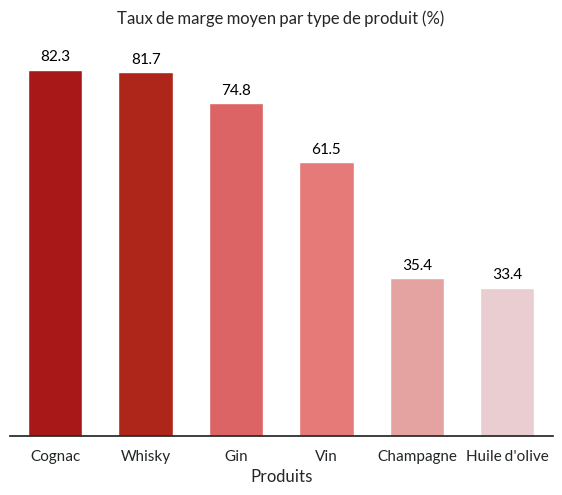

In [905]:
# Appliquer le style et le contexte personnalisés
sns.set_theme(style=custom_style, rc=custom_context)

# Création d'un histogramme avec Seaborn
graph6 = sns.barplot(x='product_type', y='taux_marge_moyen', data=taux_de_marge, palette=custom_palette, width=0.6)

# Affichage du graphique
plt.title('Taux de marge moyen par type de produit (%)', pad=20)
plt.xlabel('Produits')
plt.ylabel('Taux de marge (%)')
graph6.get_yaxis().set_visible(False)

# Suppression des bordures supérieures et droites
sns.despine(top=True, right=True, left=True)

# Ajouter des étiquettes sur chaque barre
for i, bar in enumerate(graph6.patches):
    graph6.annotate(format(bar.get_height(), '.1f'),
                (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11, color='black')
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.5 - Analyse des correlations entre les variables stock, sales et price</h3>
</div>

Création d'un heatmap de correlation avec les variables stock, sales et price

on peut également créer un mask pour n'afficher qu'une demi heatmap

In [906]:
# Renommer les colonnes en français
df_final = df_final.rename(columns={'stock_quantity': 'qte_stock', 'price': 'prix_ttc', 'total_sales':'nbre_commandes', 'purchase_price':'prix_achat'})

In [907]:
# Création d'un dataframe avec les variables quantitatives
df_heatmap = df_final.loc[:,['qte_stock','nbre_commandes','prix_achat', 'prix_ht', 'prix_ttc','taux_de_marque','taux_de_marge']]
df_heatmap.head()

,qte_stock,nbre_commandes,prix_achat,prix_ht,prix_ttc,taux_de_marque,taux_de_marge
257,0.0,6.0,20.09,32.083333,38.5,37.381818,59.698026
590,0.0,9.0,23.37,36.250000,43.5,35.531034,55.113393
531,0.0,11.0,137.81,187.500000,225.0,26.501333,36.056890
657,0.0,14.0,6.92,11.750000,14.1,41.106383,69.797688
609,0.0,6.0,13.02,20.000000,24.0,34.900000,53.609831


In [908]:
# Description du jeu de données heatmap
description_variables(df_heatmap)

Description donnée(s):
Le jeu de données comporte: 825 observation(s)
Le jeu de données comporte: 7 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
nbre_commandes,float64,825,714,24,111,13.45
prix_ht,float64,825,822,380,3,0.36
prix_ttc,float64,825,822,380,3,0.36
taux_de_marque,float64,825,822,662,3,0.36
taux_de_marge,float64,825,822,671,3,0.36
qte_stock,float64,825,823,82,2,0.24
prix_achat,float64,825,825,660,0,0.00


In [909]:
statistiques_descriptives(df_heatmap)

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
qte_stock,823,82,0.000000,145.000000,21.654921,18.000000,7.000000,23.000000,30.000000,21.918562,480.423355,2.590463,9.643406
nbre_commandes,714,24,0.000000,36.000000,8.054622,8.000000,5.000000,6.000000,11.000000,4.161344,17.316788,0.681589,3.040065
prix_achat,825,660,2.740000,137.810000,16.940582,12.710000,7.590000,14.430000,22.020000,14.561840,212.047178,2.995180,14.378175
prix_ht,822,380,4.333333,187.500000,26.958587,20.333333,12.166667,22.833333,35.000000,22.185378,492.190979,2.639051,10.858613
prix_ttc,822,380,5.200000,225.000000,32.350304,24.400000,14.600000,27.400000,42.000000,26.622453,708.755009,2.639051,10.858613
taux_de_marque,822,662,-634.988142,47.756800,36.787444,37.988902,36.134325,3.730158,39.864483,24.031587,577.517185,-26.759699,746.460658
taux_de_marge,822,671,-86.394338,91.412471,60.814679,61.261458,56.578632,9.712448,66.291079,10.612628,112.627866,-5.103385,59.165863


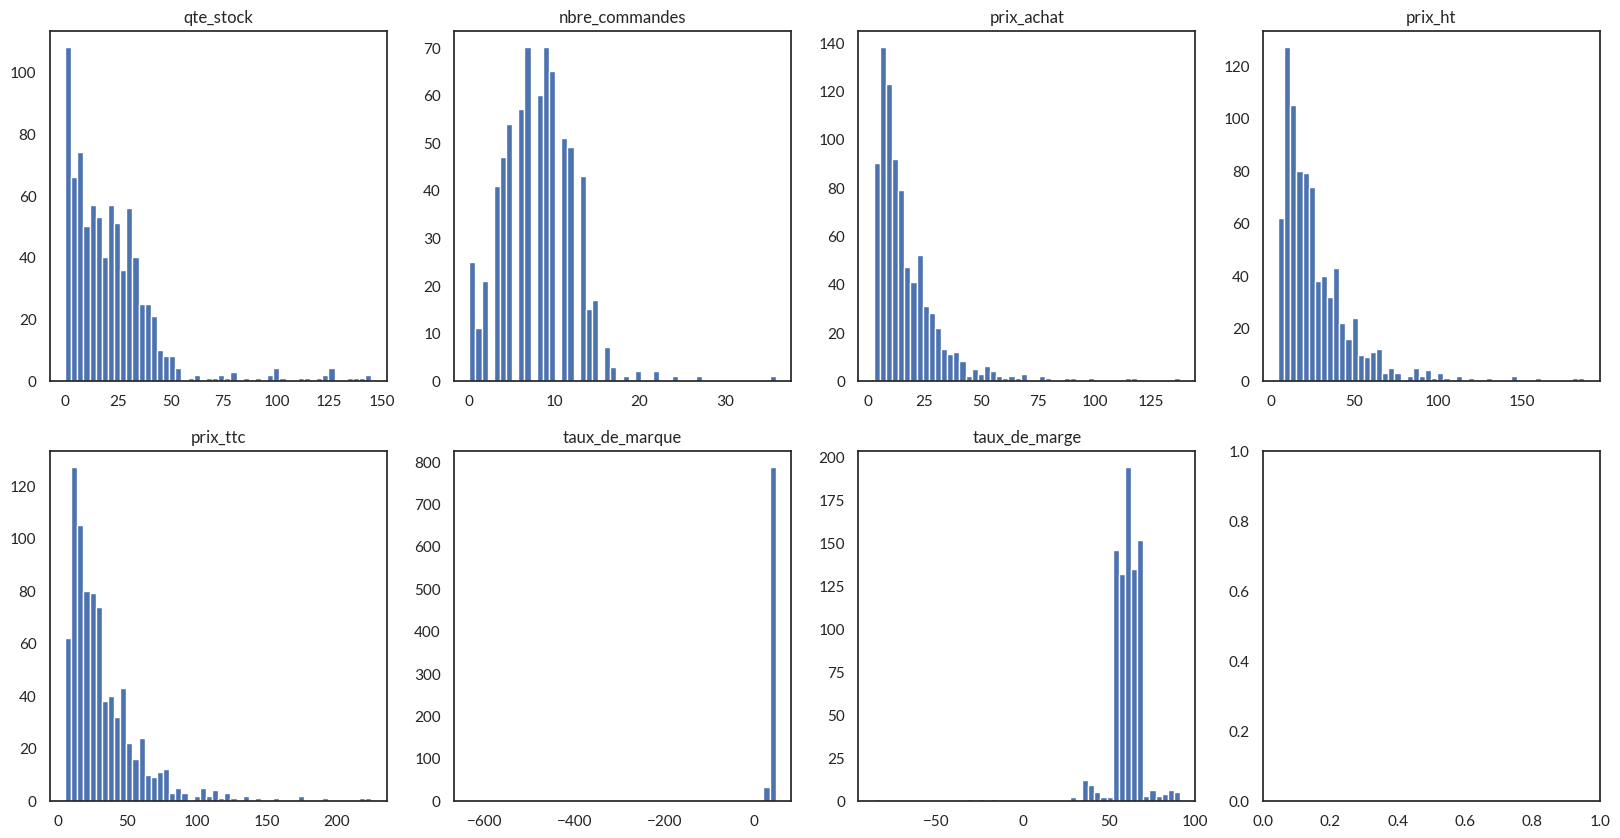

In [910]:
# Visualisation de la distribution des variables
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for i, column in enumerate(df_heatmap.columns):
    axs[i].hist(df_heatmap[column], bins=50)
    axs[i].set_title(column)

plt.show()

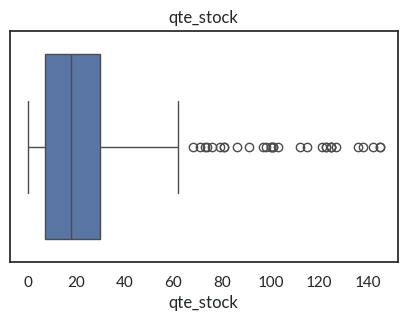

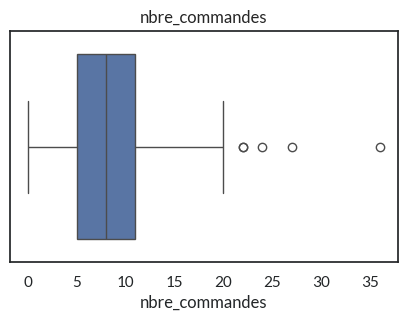

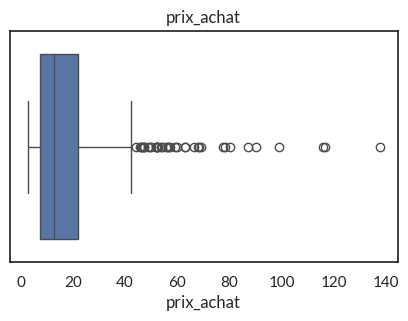

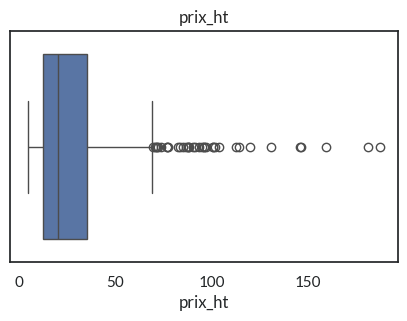

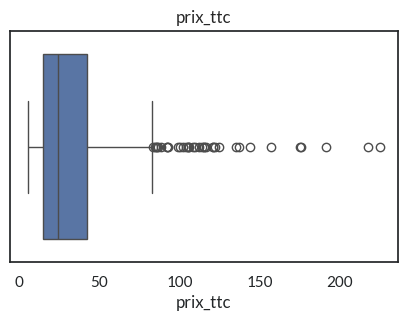

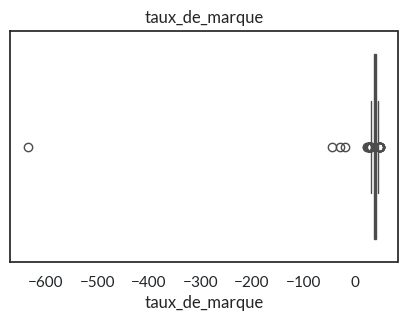

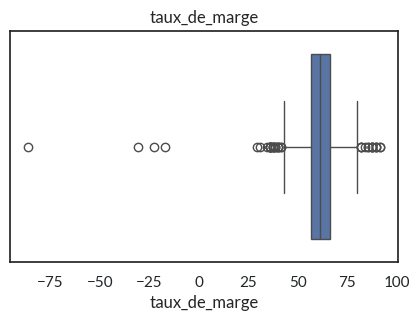

In [911]:
# Tracer les boxplots pour chaque variable
for column in df_heatmap.columns:
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df_heatmap[column], ax=ax)
    plt.title(column)
    plt.show()

In [912]:
# Réaliser la matrice de corrélation sans les données manquantes
corr = df_heatmap.corr()
corr

,qte_stock,nbre_commandes,prix_achat,prix_ht,prix_ttc,taux_de_marque,taux_de_marge
qte_stock,1.000000,0.439254,-0.013067,-0.092383,-0.092383,-0.174688,-0.365489
nbre_commandes,0.439254,1.000000,-0.503306,-0.516258,-0.516258,0.069645,0.011313
prix_achat,-0.013067,-0.503306,1.000000,0.969307,0.969307,-0.183268,-0.224024
prix_ht,-0.092383,-0.516258,0.969307,1.000000,1.000000,0.011692,-0.025677
prix_ttc,-0.092383,-0.516258,0.969307,1.000000,1.000000,0.011692,-0.025677
taux_de_marque,-0.174688,0.069645,-0.183268,0.011692,0.011692,1.000000,0.649739
taux_de_marge,-0.365489,0.011313,-0.224024,-0.025677,-0.025677,0.649739,1.000000


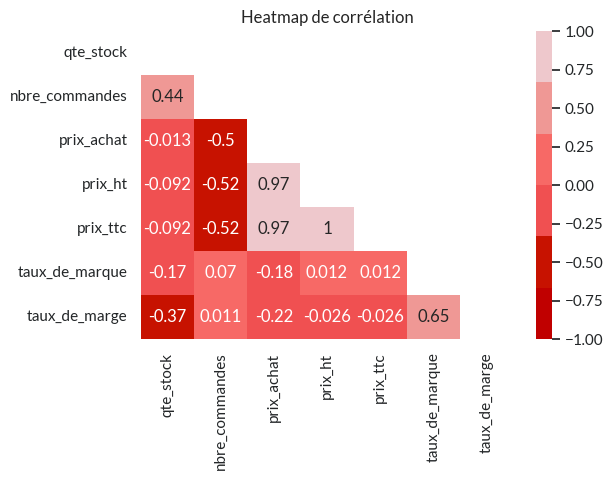

In [913]:
# Générer un mask pour une demi heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize = (6,4))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette(custom_palette))
plt.title("Heatmap de corrélation", fontsize =12)
plt.savefig("demi-heatmap2.png")

In [745]:
# Supprimer les lignes contenant des données manquantes
df_heatmap2 = df_heatmap.dropna()

In [746]:
# Réaliser la matrice de corrélation sans les données manquantes
corr = df_heatmap2.corr()
corr

,qte_stock,nbre_commandes,prix_achat,prix_ht,prix_ttc,taux_de_marque,taux_de_marge
qte_stock,1.000000,0.439254,-0.023513,-0.106098,-0.106098,-0.182857,-0.437791
nbre_commandes,0.439254,1.000000,-0.503346,-0.516321,-0.516321,0.069648,0.011325
prix_achat,-0.023513,-0.503346,1.000000,0.975957,0.975957,-0.172315,-0.192308
prix_ht,-0.106098,-0.516321,0.975957,1.000000,1.000000,0.017688,-0.011617
prix_ttc,-0.106098,-0.516321,0.975957,1.000000,1.000000,0.017688,-0.011617
taux_de_marque,-0.182857,0.069648,-0.172315,0.017688,0.017688,1.000000,0.669945
taux_de_marge,-0.437791,0.011325,-0.192308,-0.011617,-0.011617,0.669945,1.000000


In [747]:
corr.to_excel('matrice_correlation.xlsx')

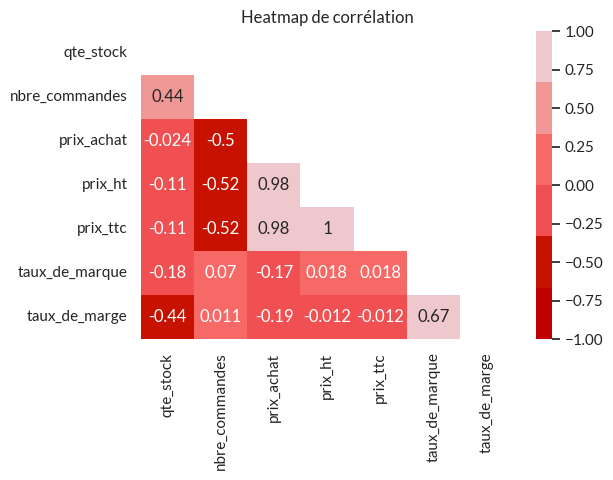

In [748]:
# Générer un mask pour une demi heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize = (6,4))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette(custom_palette))
plt.title("Heatmap de corrélation", fontsize =12)
plt.savefig("demi-heatmap.png")

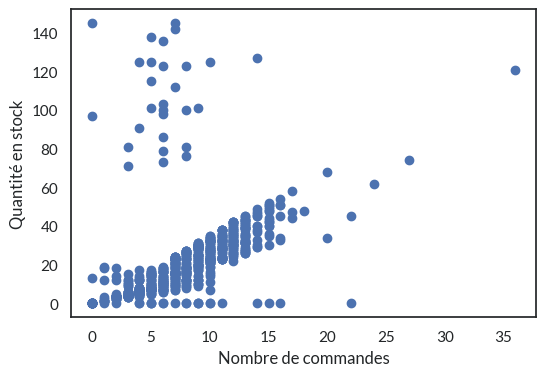

In [749]:
# Afficher un graphique nuage de points entre 2 variables
plt.figure(figsize = (6,4))
plt.plot(df_heatmap2["nbre_commandes"], df_heatmap2["qte_stock"],'o')
plt.xlabel("Nombre de commandes")
plt.ylabel("Quantité en stock")
plt.show()

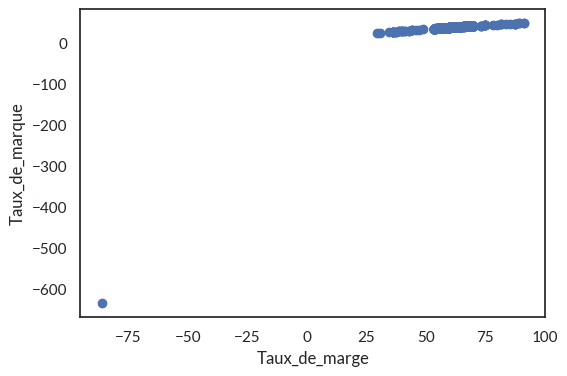

In [750]:
# Afficher un graphique nuage de points entre 2 variables
plt.figure(figsize = (6,4))
plt.plot(df_heatmap2["taux_de_marge"], df_heatmap2["taux_de_marque"],'o')
plt.xlabel("Taux_de_marge")
plt.ylabel("Taux_de_marque")
plt.show()

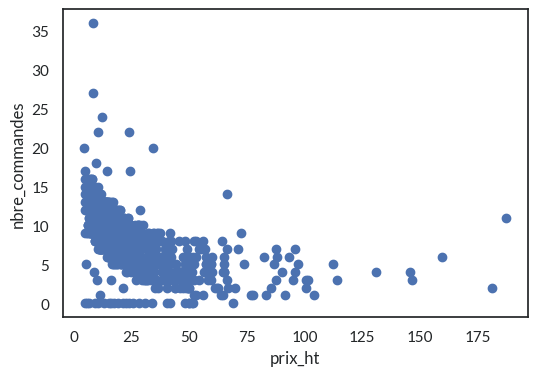

In [751]:
# Afficher un graphique nuage de points entre 2 variables
plt.figure(figsize = (6,4))
plt.plot(df_heatmap2["prix_ht"], df_heatmap2["nbre_commandes"],'o')
plt.xlabel("prix_ht")
plt.ylabel("nbre_commandes")
plt.show()

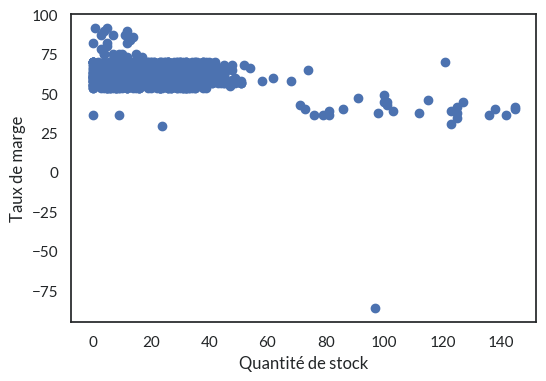

In [752]:
# Afficher un graphique nuage de points entre 2 variables
plt.figure(figsize = (6,4))
plt.plot(df_heatmap2["qte_stock"], df_heatmap2["taux_de_marge"],'o')
plt.xlabel("Quantité de stock")
plt.ylabel("Taux de marge")
plt.show()

Modéliser les régressions linéaires simples

In [754]:
# Modéliser une regression linéaire MCO
X = sm.add_constant(df_heatmap2[['nbre_commandes']])
Y = df_heatmap2["qte_stock"]
mod_1 = sm.OLS(Y, X)

# Récupérer les résultats
res_1 = mod_1.fit()

# Aficher les résultats
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:              qte_stock   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     170.0
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           5.43e-35
Time:                        13:52:26   Log-Likelihood:                -3145.7
No. Observations:                 713   AIC:                             6295.
Df Residuals:                     711   BIC:                             6305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.6018      1.630      2.

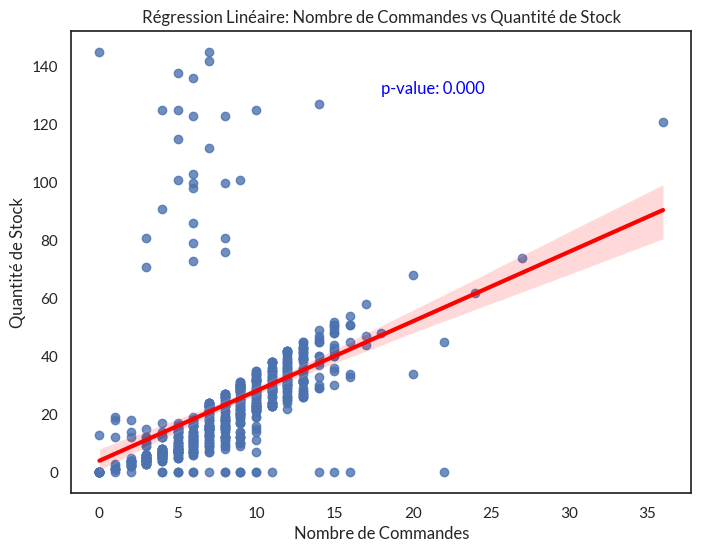

In [932]:
# Extraire la p-value
p_value = res_1.pvalues['nbre_commandes']

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(8, 6))
sns.regplot(x='nbre_commandes', y='qte_stock', data=df_heatmap2, line_kws={'color': 'red'})
plt.xlabel('Nombre de Commandes')
plt.ylabel('Quantité de Stock')
plt.title('Régression Linéaire: Nombre de Commandes vs Quantité de Stock')

# Ajouter la p-value sur le graphique
plt.text(x=df_heatmap2['nbre_commandes'].max() * 0.5, y=df_heatmap2['qte_stock'].max() * 0.9,
         s=f'p-value: {p_value:.3f}', fontsize=12, color='blue')

plt.show()

In [755]:
df_heatmap2[df_heatmap2["taux_de_marge"] < 0]

,qte_stock,nbre_commandes,prix_achat,prix_ht,prix_ttc,taux_de_marque,taux_de_marge
38,97.0,0.0,77.48,10.541667,12.65,-634.988142,-86.394338


* Utiliser les valeurs supérieures à 0 afin de réaliser le graphique et la régression linéaire. (ne pas inclure les valeurs aberrantes)

In [756]:
# Suppression de la ligne avec l'index 38
df_heatmap2.drop(38, inplace=True)
df_heatmap2.head()

C:\Users\jerem\AppData\Local\Temp\ipykernel_8532\201518803.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,qte_stock,nbre_commandes,prix_achat,prix_ht,prix_ttc,taux_de_marque,taux_de_marge
257,0.0,6.0,20.09,32.083333,38.5,37.381818,59.698026
590,0.0,9.0,23.37,36.250000,43.5,35.531034,55.113393
531,0.0,11.0,137.81,187.500000,225.0,26.501333,36.056890
657,0.0,14.0,6.92,11.750000,14.1,41.106383,69.797688
609,0.0,6.0,13.02,20.000000,24.0,34.900000,53.609831


In [757]:
df_heatmap2[df_heatmap2["taux_de_marge"] < 0]

,qte_stock,nbre_commandes,prix_achat,prix_ht,prix_ttc,taux_de_marque,taux_de_marge


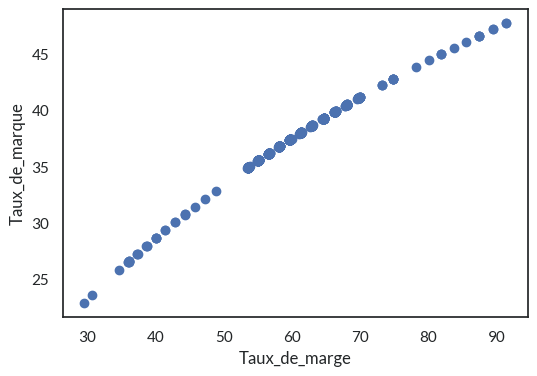

In [762]:
# Afficher un graphique nuage de points entre 2 variables
plt.figure(figsize = (6,4))
plt.plot(df_heatmap2["taux_de_marge"], df_heatmap2["taux_de_marque"],'o')
plt.xlabel("Taux_de_marge")
plt.ylabel("Taux_de_marque")
plt.show()

In [759]:
# Modéliser une regression linéaire MCO
X2 = sm.add_constant(df_heatmap2[['taux_de_marge']])
Y2 = df_heatmap2["taux_de_marque"] 

mod_2 = sm.OLS(Y2, X2)

# Récupérer les résultats
res_2 = mod_2.fit()

# Afficher les résultats
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:         taux_de_marque   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 6.049e+04
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:53:14   Log-Likelihood:                -235.50
No. Observations:                 712   AIC:                             475.0
Df Residuals:                     710   BIC:                             484.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.6822      0.099    138.277

Text(45.70623545265221, 42.98112, 'p-value: 0.000')

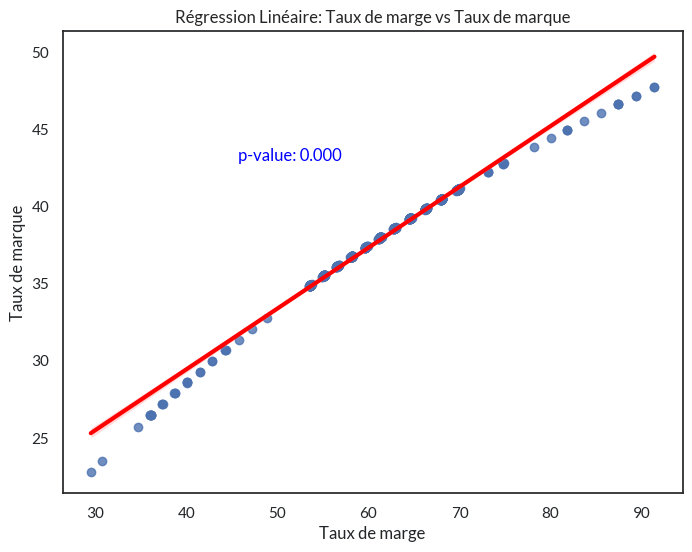

In [926]:
# Extraire la p-value
p_value = res_2.pvalues['taux_de_marge']

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(8, 6))
sns.regplot(x='taux_de_marge', y='taux_de_marque', data=df_heatmap2, line_kws={'color': 'red'})
plt.xlabel('Taux de marge')
plt.ylabel('Taux de marque')
plt.title('Régression Linéaire: Taux de marge vs Taux de marque')

# Ajouter la p-value sur le graphique
plt.text(x=df_heatmap2['taux_de_marge'].max() * 0.5, y=df_heatmap2['taux_de_marque'].max() * 0.9,
         s=f'p-value: {p_value:.3f}', fontsize=12, color='blue')

In [768]:
# Modéliser une regression linéaire MCO
X3 = sm.add_constant(df_heatmap2[['prix_ht']])
Y3 = df_heatmap2["nbre_commandes"]
mod_3 = sm.OLS(Y3, X3)

# Récupérer les résultats
res_3 = mod_3.fit()

# Afficher les résultats
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:         nbre_commandes   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     262.9
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           1.57e-50
Time:                        14:16:31   Log-Likelihood:                -1912.0
No. Observations:                 712   AIC:                             3828.
Df Residuals:                     710   BIC:                             3837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5959      0.205     51.655      0.0

Text(93.75, 32.4, 'p-value: 0.000')

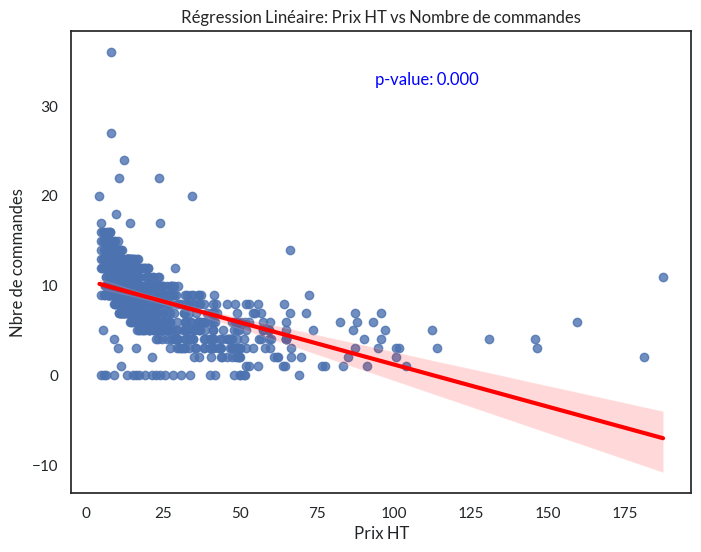

In [927]:
# Extraire la p-value
p_value = res_3.pvalues['prix_ht']

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(8, 6))
sns.regplot(x='prix_ht', y='nbre_commandes', data=df_heatmap2, line_kws={'color': 'red'})
plt.xlabel('Prix HT')
plt.ylabel('Nbre de commandes')
plt.title('Régression Linéaire: Prix HT vs Nombre de commandes')

# Ajouter la p-value sur le graphique
plt.text(x=df_heatmap2['prix_ht'].max() * 0.5, y=df_heatmap2['nbre_commandes'].max() * 0.9,
         s=f'p-value: {p_value:.3f}', fontsize=12, color='blue')

In [928]:
# Modéliser une regression linéaire MCO
X4 = sm.add_constant(df_heatmap2[['taux_de_marge']])
Y4 = df_heatmap2["qte_stock"]
mod_4 = sm.OLS(Y4, X4)

# Récupérer les résultats
res_4 = mod_4.fit()

# Afficher les résultats
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:              qte_stock   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     181.4
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           5.43e-37
Time:                        15:24:36   Log-Likelihood:                -3131.6
No. Observations:                 712   AIC:                             6267.
Df Residuals:                     710   BIC:                             6276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           100.5886      5.780     17.404

Text(82.27122381477398, 130.5, 'p-value: 0.000')

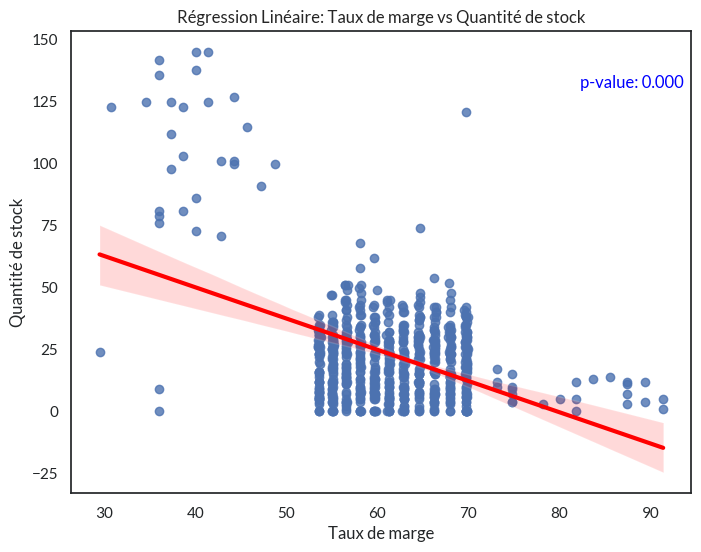

In [931]:
# Extraire la p-value
p_value = res_4.pvalues['taux_de_marge']

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(8, 6))
sns.regplot(x='taux_de_marge', y='qte_stock', data=df_heatmap2, line_kws={'color': 'red'})
plt.xlabel('Taux de marge')
plt.ylabel('Quantité de stock')
plt.title('Régression Linéaire: Taux de marge vs Quantité de stock')

# Ajouter la p-value sur le graphique
plt.text(x=df_heatmap2['taux_de_marge'].max() * 0.9, y=df_heatmap2['qte_stock'].max() * 0.9,
         s=f'p-value: {p_value:.3f}', fontsize=12, color='blue')

## Conclusions

In [153]:
# Filtrer les lignes où prix d'achat est inférieur à prix de vente
df_filtre = df_final.loc[df_final['prix_achat'] > df_final['prix_ttc']]

print("\nLignes où prix de vente est inférieur au prix d'achat:")
df_filtre


Lignes où prix de vente est inférieur au prix d'achat:


,product_id,onsale_web,prix_ttc,qte_stock,prix_achat,stock_status_2,sku,df1_merge,virtual,downloadable,rating_count,average_rating,nbre_commandes,post_author,post_date,post_date_gmt,product_type,post_title,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,zscore,ca_par_article,ca_%,ca_%_cumul,total_sales_%,total_sales_%_cumul,couverture_de_stock,valorisation_des_stocks_(€),prix_ht,marge_commerciale,taux_de_marque,taux_de_marge
38,4355,1,12.65,97.0,77.48,instock,12589,both,0.0,0.0,0.0,0.0,0.0,2.0,2018-03-02 10:46:10,2018-03-02 09:46:10,Champagne,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,publish,closed,closed,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,2020-08-13 10:15:02,2020-08-13 08:15:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,-0.739988,0.0,0.0,100.0,0.0,100.0,inf,7515.56,10.541667,-66.938333,-634.988142,-86.394338
267,4864,0,8.30,0.0,9.99,outofstock,15154,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.903384,NaN,NaN,NaN,NaN,NaN,NaN,0.00,6.916667,-3.073333,-44.433735,-30.764097
769,6324,0,92.00,18.0,99.00,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,2.240578,NaN,NaN,NaN,NaN,NaN,NaN,1782.00,76.666667,-22.333333,-29.130435,-22.558923
819,7196,0,31.00,55.0,31.20,instock,NaN,both,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only,-0.050721,NaN,NaN,NaN,NaN,NaN,NaN,1716.00,25.833333,-5.366667,-20.774194,-17.200855


In [154]:
# Vente promotionnelle avec coupon
df_final.loc[df_final['sku']=='bon-cadeau-25-euros', ['product_id','onsale_web', 'prix_achat', 'prix_ttc', 'qte_stock', 'nbre_commandes','product_type' ,'stock_status_2',]]

,product_id,onsale_web,prix_achat,prix_ttc,qte_stock,nbre_commandes,product_type,stock_status_2
824,4954,1,13.3,25.0,23.0,7.0,NaN,instock


* 4 tarifs doivent être corrigés dans l'ERP car ceux ci présentent un prix de vente inférieur à leur prix d'achat.

* Malgré un sku différent, le code promo doit être conservé car il dispose d'une **commande de 7 articles** mais également de l'ensemble des informations principales telles que les quantités de stocks, le prix d'achat, le prix de vente, ainsi qu'un id produit. Cependant il manque le product_id associé à cette vente.

* Normaliser la table web avec la création, entre autres d'une table promotion avec ses attributs.

* 91 id_web sont manquants dans le fichier liaison. Ce qui nécessite de supprimer les id qui ne correspondent à aucun article si ceux ci ne sont plus commercialisés.

* L'analyse de corrélations et les régressions linéaires réalisées démontrent que le nombre de commandes augmentent avec la quantité de stock disponible. A l'inverse le nombres de commandes diminuent lorsque les prix sont élevés. Enfin la rentabilité progresse logiquement avec une marge qui augmente.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.6 - Mettre à disposition la nouvelle table sur un fichier Excel</h3>
</div>

In [155]:
#Mettre le dataset df_merge sur un fichier Excel
#Cette étape peut-être utile pour partager le résultat du dataset obtenu pour le partager avec les équipes.  
df_final.to_excel('ventes_bottleneck.xlsx')